## Entraînement de modèles uniclasse et multilabels

Sur la base des données assemblées sur le notebook `second_iteration_dataset.ipynb`

In [22]:
import pandas as pd
import swifter
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt import load

import lightgbm as lgb

from sklearn.model_selection import train_test_split

from utils.map12_from_score_table import map12_from_score_table
import shap


%load_ext autoreload
%autoreload 2

features_sets = [
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list', 'age_ratio', 'index_ratio'], # Uniquement les infos de sélection
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list', 'total_purchases', 'average_quantity', 'average_price',
       'has_image', 'age_around_15_article', 'age_around_25_article',
       'age_around_35_article', 'age_around_45_article',
       'age_around_55_article', 'age_around_65_article', 'repurchases_article',
       'repurchase_interval', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_customer', 'repurchases_interval',
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'age_ratio', 'index_ratio'], # Infos de sélections + de ventes
    [
       'product_type_name', 'product_group_name', 'graphical_appearance_name',
       'colour_group_name', 'perceived_colour_value_name',
       'perceived_colour_master_name', 'department_name', 
       'index_name', 'index_group_name', 'section_name', 'garment_group_name',
       'total_purchases', 'average_quantity', 'average_price',
       'has_image', 'age_around_15_article', 'age_around_25_article',
       'age_around_35_article', 'age_around_45_article',
       'age_around_55_article', 'age_around_65_article', 'repurchases_article',
       'repurchase_interval', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_customer', 'repurchases_interval',
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'postal_code_group',
       'group', 'age_ratio', 'index_ratio'], # Sans les infos de sélection
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list',
       'product_type_name', 'product_group_name', 'graphical_appearance_name',
       'colour_group_name', 'perceived_colour_value_name',
       'perceived_colour_master_name', 'department_name', 
       'index_name', 'index_group_name', 'section_name', 'garment_group_name',
       'has_image', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'postal_code_group',
       'group', 'age_ratio', 'index_ratio'], # Sans les infos de vente
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list', 
       'product_group_name',
       'perceived_colour_value_name',
       'perceived_colour_master_name', 
       'index_name', 'index_group_name', 'section_name', 'garment_group_name',
       'total_purchases', 'average_quantity', 'average_price',
       'has_image', 'age_around_15_article', 'age_around_25_article',
       'age_around_35_article', 'age_around_45_article',
       'age_around_55_article', 'age_around_65_article', 'repurchases_article',
       'repurchase_interval', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_customer', 'repurchases_interval',
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'postal_code_group',
       'group', 'age_ratio', 'index_ratio'], # Uniquement certaines catégories
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list',
       'product_type_name', 'product_group_name', 'graphical_appearance_name',
       'colour_group_name', 'perceived_colour_value_name',
       'perceived_colour_master_name', 'department_name', 
       'index_name', 'index_group_name', 'section_name', 'garment_group_name',
       'total_purchases', 'average_quantity', 'average_price',
       'has_image', 'age_around_15_article', 'age_around_25_article',
       'age_around_35_article', 'age_around_45_article',
       'age_around_55_article', 'age_around_65_article', 'repurchases_article',
       'repurchase_interval', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_customer', 'repurchases_interval',
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'postal_code_group',
       'group', 'age_ratio', 'index_ratio'], # Toutes les infos
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Modèle uniclasse - LightGBM
#### Préparation des données

In [23]:
data_uniclass = pd.read_pickle('pickles/second_iteration_data_train_uniclass.pkl')
data_uniclass.head(5)

customer_id  article_id  label  \
0  ed99cc34c86d4871bfddddc012f0ce2bac9ad14c7fc61f...  0714790020      0   
1  55b4916d32a641e3626a4da567bead084c62ca4ab97d58...  0871710001      0   
2  c9b428898d8353d2ae7470ef420b708825c13be2fecd41...  0935892001      0   
3  67852e732eda81a5f8e5661fe114e5ca17b870ba2df063...  0797710006      0   
4  0b423caa0ad781da963730635e7eac1c7653662ef8f7ee...  0923758001      0   

   in_pair_list  in_repurchase_list  in_cross_list product_code  \
0           100                 100             27      0714790   
1           100                 100             46      0871710   
2           100                 100             72      0935892   
3           100                 100             63      0797710   
4           100                 100             14      0923758   

                      prod_name product_type_name  product_group_name  ...  \
0              Mom Fit Ultra HW          Trousers  Garment Lower body  ...   
1            SPEED BRUNO  SHIRT             Shirt  Garment Upper body  ...   
2  LW (J) Conc PRICE SWEATSHIRT               Bra           Underwear  ...   
3              Teddy turtleneck               Top  Garment Upper body  ...   
4                       Vanessa           Unknown             Unknown  ...   

  age_around_15_customer age_around_25_customer age_around_35_customer  \
0                    0.0                    0.7                    0.3   
1                    0.2                    0.8                    0.0   
2                    0.5                    0.5                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

  age_around_45_customer age_around_55_customer age_around_65_customer  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.4                    0.6                    0.0   
4                    0.3                    0.7                    0.0   

  postal_code_group group age_ratio index_ratio  
0                 5     9  0.389226    0.300000  
1                 3     9  0.456370    0.222222  
2                 5     0  0.192645    0.933333  
3                 4     5  0.232025    0.846827  
4                 4     4  0.156613    0.717949  

[5 rows x 62 columns]

In [24]:
# Division du dataset en entraînement / validation
# Doit être fait par client afin de préserver le scoring MAP@12.
customers = data_uniclass['customer_id'].unique()

customers_train, customers_valid = train_test_split(customers, test_size=0.2)

data_train = data_uniclass[data_uniclass['customer_id'].isin(customers_train)]
data_valid = data_uniclass[data_uniclass['customer_id'].isin(customers_valid)]

data_train.sort_values('customer_id', inplace = True)
data_valid.sort_values('customer_id', inplace = True)

# Création des groupes pour l'application de la métrique MAP@12 dans lightGBM
groups_train = data_train.groupby('customer_id', sort = False)['customer_id'].count().values
groups_valid = data_valid.groupby('customer_id', sort = False)['customer_id'].count().values


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Recherche d'hyperparamètres

In [57]:

# Définition d'une classe contenant les valeurs possibles des paramètres.
class SearchableHyperparameters:

    def __init__(self):
        
        self.colsample_bytree = Real(low=0.4, high=0.6, prior='uniform',
                          name='colsample_bytree')
        
        self.feature_set  = Categorical(
            categories=[1, 2, 4],
            name='feature_set')
        
        
        self.min_child_samples = Integer(low=100, high=500,
                                       name='min_child_samples')
        
        self.min_child_weight = Categorical(
            categories=[1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            name='min_child_weight')
        
        self.num_leaves = Integer(low=6, high=50,
                                       name='num_leaves')
        
        
        self.objective = Categorical(
            categories=['binary', 'lambdarank', 'cross_entropy', 'cross_entropy_lambda'],
            name='objective')
        
        self.reg_alpha = Categorical(
            categories=[0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            name='reg_alpha')
        
        self.reg_lambda = Categorical(
            categories=[0, 1e-1, 1, 5, 10, 20, 50, 100],
            name='reg_lambda')
            
        self.subsample = Real(low=0.2, high=0.8, prior='uniform',
                          name='subsample')
        
        
        self.dimensions = [self.__getattribute__(attr)
                           for attr in dir(self) if '__' not in attr]
        
            
        self.default_parameters = [0.6, 2, 400, 1e-5, 35, 'lambdarank', 2, 20, 0.28]

searchable_params = SearchableHyperparameters()

In [10]:
# Création d'un dataframe pour enregistrer les paramètres
search_results = pd.DataFrame(columns = [])
search_results.to_pickle("pickles/second_iteration_search_results.pkl")

In [60]:

    
@use_named_args(dimensions=searchable_params.dimensions)
def search(**search_params):
    """Fonction d'entraînement du modèle. """
    global data_train, groups_train, data_valid, groups_valid, features_sets
    
    search_params['metric'] = 'map'
    search_params['eval_at'] = 12,
    
    print("Search params : ", search_params)
    
    feature_set = features_sets[search_params['feature_set']]
    
    params = search_params.copy()
    del params['feature_set']
    
    X_train = data_train[feature_set]
    Y_train = data_train['label']
    X_valid = data_valid[feature_set]
    Y_valid = data_valid['label']

    train_dataset = lgb.Dataset(X_train, label=Y_train, group = groups_train)
    validation_dataset = train_dataset.create_valid(X_valid, label = Y_valid, group = groups_valid)

    num_round = 1000
    bst = lgb.train(params, train_dataset, num_round, valid_sets=[validation_dataset], callbacks=[lgb.early_stopping(stopping_rounds=100)])
    
    preds = bst.predict(data_valid[feature_set])
    
    # Calculate MAP@12
    score_table = pd.concat([
        data_valid['customer_id'].reset_index(drop = True), 
        data_valid['label'].reset_index(drop = True), 
        pd.Series(preds).rename('prediction')
    ], axis = 1).sort_values(
        ['customer_id', 'prediction'], ascending = False
    )

    best_score = next(iter(bst.best_score['valid_0'].items()))[1]

    map12 = map12_from_score_table(score_table)['map12'].mean()
    
    # Sauvegarde du résultat dans le tableau.
    search_result_table = pd.read_pickle("pickles/second_iteration_search_results.pkl")
    
    new_row = []
    for key in search_params.keys():
        new_row.append(search_params[key])

    new_row.append(best_score)
    new_row.append(map12)
        
    new_row = pd.DataFrame([new_row], columns = [*search_params.keys(), 'best_score', 'map12'])
    search_result_table = pd.concat([search_result_table, new_row], axis = 0) 
    
    search_result_table.to_pickle("pickles/second_iteration_search_results.pkl")
    
    
    return -map12


In [61]:
search_result = gp_minimize(
    func=search,
    dimensions=searchable_params.dimensions,
    n_calls=200,
    acq_func='EI',
    x0=searchable_params.default_parameters,
    verbose = True
)


[239]	valid_0's map@12: 0.772041
[240]	valid_0's map@12: 0.772037
[241]	valid_0's map@12: 0.772117
[242]	valid_0's map@12: 0.772105
[243]	valid_0's map@12: 0.772101
[244]	valid_0's map@12: 0.772019
[245]	valid_0's map@12: 0.772041
[246]	valid_0's map@12: 0.772048
[247]	valid_0's map@12: 0.772107
[248]	valid_0's map@12: 0.772128
[249]	valid_0's map@12: 0.772139
[250]	valid_0's map@12: 0.772024
[251]	valid_0's map@12: 0.771997
[252]	valid_0's map@12: 0.772037
[253]	valid_0's map@12: 0.772052
[254]	valid_0's map@12: 0.772005
[255]	valid_0's map@12: 0.77199
[256]	valid_0's map@12: 0.77198
[257]	valid_0's map@12: 0.771956
[258]	valid_0's map@12: 0.771981
[259]	valid_0's map@12: 0.771964
[260]	valid_0's map@12: 0.771942
[261]	valid_0's map@12: 0.7723
[262]	valid_0's map@12: 0.772464
[263]	valid_0's map@12: 0.77253
[264]	valid_0's map@12: 0.772504
[265]	valid_0's map@12: 0.772475
[266]	valid_0's map@12: 0.772441
[267]	valid_0's map@12: 0.772385
[268]	valid_0's map@12: 0.772388
[269]	valid_0's

invalid value encountered in double_scalars


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 28.1171
Function value obtained: -0.1326
Current minimum: -0.1336
Iteration No: 117 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.41380704236333304, 'feature_set': 2, 'min_child_samples': 336, 'min_child_weight': 10.0, 'num_leaves': 50, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 0.1, 'subsample': 0.7891520583755856, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 51


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.712509
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.717615
[3]	valid_0's map@12: 0.723576
[4]	valid_0's map@12: 0.725376
[5]	valid_0's map@12: 0.726568
[6]	valid_0's map@12: 0.72781
[7]	valid_0's map@12: 0.728303
[8]	valid_0's map@12: 0.728614
[9]	valid_0's map@12: 0.72963
[10]	valid_0's map@12: 0.730146
[11]	valid_0's map@12: 0.730934
[12]	valid_0's map@12: 0.732371
[13]	valid_0's map@12: 0.732514
[14]	valid_0's map@12: 0.732658
[15]	valid_0's map@12: 0.733325
[16]	valid_0's map@12: 0.733593
[17]	valid_0's map@12: 0.734266
[18]	valid_0's map@12: 0.734515
[19]	valid_0's map@12: 0.734481
[20]	valid_0's map@12: 0.734946
[21]	valid_0's map@12: 0.735603
[22]	valid_0's map@12: 0.735607
[23]	valid_0's map@12: 0.735739
[24]	valid_0's map@12

invalid value encountered in double_scalars


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 24.1694
Function value obtained: -0.1042
Current minimum: -0.1336
Iteration No: 118 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5246666755254995, 'feature_set': 1, 'min_child_samples': 100, 'min_child_weight': 10.0, 'num_leaves': 46, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 50.0, 'subsample': 0.8, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info

invalid value encountered in double_scalars


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 22.2106
Function value obtained: -0.1325
Current minimum: -0.1336
Iteration No: 119 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4839210429046745, 'feature_set': 1, 'min_child_samples': 500, 'min_child_weight': 1000.0, 'num_leaves': 28, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 20.0, 'subsample': 0.2, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [In

invalid value encountered in double_scalars


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 37.9902
Function value obtained: -0.1301
Current minimum: -0.1336
Iteration No: 120 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4, 'feature_set': 1, 'min_child_samples': 500, 'min_child_weight': 100.0, 'num_leaves': 35, 'objective': 'cross_entropy_lambda', 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'subsample': 0.8, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info]

invalid value encountered in double_scalars


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 20.2974
Function value obtained: -0.1318
Current minimum: -0.1336
Iteration No: 121 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4, 'feature_set': 1, 'min_child_samples': 500, 'min_child_weight': 1000.0, 'num_leaves': 50, 'objective': 'cross_entropy', 'reg_alpha': 100.0, 'reg_lambda': 0.1, 'subsample': 0.8, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total grou

invalid value encountered in double_scalars


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 22.8245
Function value obtained: -0.1235
Current minimum: -0.1336
Iteration No: 122 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4130466302472932, 'feature_set': 4, 'min_child_samples': 478, 'min_child_weight': 100.0, 'num_leaves': 38, 'objective': 'lambdarank', 'reg_alpha': 100.0, 'reg_lambda': 10.0, 'subsample': 0.8, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.712098
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.73155
[3]	valid_0's map@12: 0.756069
[4]	valid_0's map@12: 0.755969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@12: 0.758987
[6]	valid_0's map@12: 0.760038
[7]	valid_0's map@12: 0.759809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's map@12: 0.759964
[9]	valid_0's map@12: 0.760004
[10]	valid_0's map@12: 0.760195
[11]	valid_0's map@12: 0.76026
[12]	valid_0's map@12: 0.759939
[13]	valid_0's map@12: 0.760304
[14]	valid_0's map@12: 0.760714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	valid_0's map@12: 0.760824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's map@12: 0.760843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]

invalid value encountered in double_scalars


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 25.4992
Function value obtained: -0.1238
Current minimum: -0.1336
Iteration No: 123 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4896453862613421, 'feature_set': 1, 'min_child_samples': 352, 'min_child_weight': 1000.0, 'num_leaves': 33, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 50.0, 'subsample': 0.20000039626058627, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] To

invalid value encountered in double_scalars


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 41.0847
Function value obtained: -0.1305
Current minimum: -0.1336
Iteration No: 124 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.44227297734017673, 'feature_set': 4, 'min_child_samples': 225, 'min_child_weight': 1000.0, 'num_leaves': 50, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 50.0, 'subsample': 0.2, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's map@12: 0.700634
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's map@12: 0.717272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@12: 0.725095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's map@12: 0.72546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@12: 0.725458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's map@12: 0.726808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's map@12: 0.7

invalid value encountered in double_scalars


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 43.0921
Function value obtained: -0.1307
Current minimum: -0.1336
Iteration No: 125 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5903977838653225, 'feature_set': 4, 'min_child_samples': 425, 'min_child_weight': 1.0, 'num_leaves': 42, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.2710907942348931, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.707393
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.748333
[3]	valid_0's map@12: 0.754196
[4]	valid_0's map@12: 0.755783
[5]	valid_0's map@12: 0.757348
[6]	valid_0's map@12: 0.759366
[7]	valid_0's map@12: 0.758611
[8]	valid_0's map@12: 0.758599
[9]	valid_0's map@12: 0.75984
[10]	valid_0's map@12: 0.761017
[11]	valid_0's map@12: 0.761791
[12]	valid_0's map@12: 0.762118
[13]	valid_0's map@12: 0.76243
[14]	valid_0's map@12: 0.762124
[15]	valid_0's map@12: 0.762532
[16]	valid_0's map@12: 0.762758
[17]	valid_0's map@12: 0.762836
[18]	valid_0's map@12: 0.762813
[19]	valid_0's map@12: 0.762914
[20]	valid_0's map@12: 0.763129
[21]	valid_0's map@12: 0.764019
[22]	valid_0's map@12: 0.763864
[23]	valid_0's map@12: 0.764354
[24]	valid

invalid value encountered in double_scalars


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 25.5363
Function value obtained: -0.1321
Current minimum: -0.1336
Iteration No: 126 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5645457505299849, 'feature_set': 2, 'min_child_samples': 298, 'min_child_weight': 0.001, 'num_leaves': 24, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 20.0, 'subsample': 0.7915931762831743, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 51


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.710462
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.713426
[3]	valid_0's map@12: 0.716153
[4]	valid_0's map@12: 0.719893
[5]	valid_0's map@12: 0.720391
[6]	valid_0's map@12: 0.721249
[7]	valid_0's map@12: 0.72299
[8]	valid_0's map@12: 0.722397
[9]	valid_0's map@12: 0.723923
[10]	valid_0's map@12: 0.724957
[11]	valid_0's map@12: 0.725657
[12]	valid_0's map@12: 0.726062
[13]	valid_0's map@12: 0.726371
[14]	valid_0's map@12: 0.726004
[15]	valid_0's map@12: 0.726397
[16]	valid_0's map@12: 0.727268
[17]	valid_0's map@12: 0.72842
[18]	valid_0's map@12: 0.729276
[19]	valid_0's map@12: 0.729407
[20]	valid_0's map@12: 0.729841
[21]	valid_0's map@12: 0.729925
[22]	valid_0's map@12: 0.730303
[23]	valid_0's map@12: 0.730503
[24]	valid_0's map@12

invalid value encountered in double_scalars


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 35.6190
Function value obtained: -0.1066
Current minimum: -0.1336
Iteration No: 127 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5392792243187122, 'feature_set': 1, 'min_child_samples': 442, 'min_child_weight': 0.001, 'num_leaves': 20, 'objective': 'cross_entropy', 'reg_alpha': 100.0, 'reg_lambda': 1.0, 'subsample': 0.7731729445828839, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36

invalid value encountered in double_scalars


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 18.0977
Function value obtained: -0.1253
Current minimum: -0.1336
Iteration No: 128 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5050170680513677, 'feature_set': 1, 'min_child_samples': 389, 'min_child_weight': 0.1, 'num_leaves': 50, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 0.1, 'subsample': 0.24183649400362453, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[L

invalid value encountered in double_scalars


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 22.4157
Function value obtained: -0.1309
Current minimum: -0.1336
Iteration No: 129 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4645771435763119, 'feature_set': 4, 'min_child_samples': 160, 'min_child_weight': 0.1, 'num_leaves': 41, 'objective': 'cross_entropy', 'reg_alpha': 0.1, 'reg_lambda': 50.0, 'subsample': 0.701320850838071, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.709654
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.727273
[3]	valid_0's map@12: 0.75107
[4]	valid_0's map@12: 0.752217
[5]	valid_0's map@12: 0.7549
[6]	valid_0's map@12: 0.757816
[7]	valid_0's map@12: 0.757772
[8]	valid_0's map@12: 0.758645
[9]	valid_0's map@12: 0.759829
[10]	valid_0's map@12: 0.760609
[11]	valid_0's map@12: 0.76055
[12]	valid_0's map@12: 0.760878
[13]	valid_0's map@12: 0.761118
[14]	valid_0's map@12: 0.761448
[15]	valid_0's map@12: 0.761509
[16]	valid_0's map@12: 0.761461
[17]	valid_0's map@12: 0.761531
[18]	valid_0's map@12: 0.762096
[19]	valid_0's map@12: 0.761934
[20]	valid_0's map@12: 0.762441
[21]	valid_0's map@12: 0.763268
[22]	valid_0's map@12: 0.762999
[23]	valid_0's map@12: 0.762846
[24]	valid_0

invalid value encountered in double_scalars


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 34.4196
Function value obtained: -0.1337
Current minimum: -0.1337
Iteration No: 130 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4786103359334824, 'feature_set': 2, 'min_child_samples': 351, 'min_child_weight': 0.1, 'num_leaves': 43, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 50.0, 'subsample': 0.22015241729965604, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 51


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.714542
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.72179
[3]	valid_0's map@12: 0.724705
[4]	valid_0's map@12: 0.727407
[5]	valid_0's map@12: 0.73009
[6]	valid_0's map@12: 0.732029
[7]	valid_0's map@12: 0.733034
[8]	valid_0's map@12: 0.734747
[9]	valid_0's map@12: 0.734779
[10]	valid_0's map@12: 0.736524
[11]	valid_0's map@12: 0.736901
[12]	valid_0's map@12: 0.737904
[13]	valid_0's map@12: 0.73747
[14]	valid_0's map@12: 0.738078
[15]	valid_0's map@12: 0.738535
[16]	valid_0's map@12: 0.739365
[17]	valid_0's map@12: 0.739591
[18]	valid_0's map@12: 0.739557
[19]	valid_0's map@12: 0.739972
[20]	valid_0's map@12: 0.740283
[21]	valid_0's map@12: 0.740573
[22]	valid_0's map@12: 0.74042
[23]	valid_0's map@12: 0.740171
[24]	valid_0's map@12: 0.740254
[25]	valid_0's map@12: 0.740657
[26]	valid_0's map@12: 0.741115
[27]	valid_0's map@12: 0.741518
[28]	valid_0's map@12: 0.7415

invalid value encountered in double_scalars


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 32.7301
Function value obtained: -0.1068
Current minimum: -0.1337
Iteration No: 131 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5025257706228468, 'feature_set': 2, 'min_child_samples': 160, 'min_child_weight': 1000.0, 'num_leaves': 14, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 0.1, 'subsample': 0.7811452793555513, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 51


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.707295
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.712447
[3]	valid_0's map@12: 0.717667
[4]	valid_0's map@12: 0.72214
[5]	valid_0's map@12: 0.724226
[6]	valid_0's map@12: 0.725304
[7]	valid_0's map@12: 0.726041
[8]	valid_0's map@12: 0.727643
[9]	valid_0's map@12: 0.728901
[10]	valid_0's map@12: 0.729157
[11]	valid_0's map@12: 0.72913
[12]	valid_0's map@12: 0.729592
[13]	valid_0's map@12: 0.729166
[14]	valid_0's map@12: 0.729234
[15]	valid_0's map@12: 0.730208
[16]	valid_0's map@12: 0.730683
[17]	valid_0's map@12: 0.730565
[18]	valid_0's map@12: 0.73027
[19]	valid_0's map@12: 0.729952
[20]	valid_0's map@12: 0.730341
[21]	valid_0's map@12: 0.731062
[22]	valid_0's map@12: 0.731539
[23]	valid_0's map@12: 0.731974
[24]	valid_0's map@12: 0.731778
[25]	valid_0's map@12: 0.732514
[26]	valid_0's map@12: 0.732884
[27]	valid_0's map@12: 0.73342
[28]	valid_0's map@12: 0.7342

invalid value encountered in double_scalars


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 50.8644
Function value obtained: -0.1064
Current minimum: -0.1337
Iteration No: 132 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5845394746838286, 'feature_set': 1, 'min_child_samples': 395, 'min_child_weight': 1.0, 'num_leaves': 11, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 20.0, 'subsample': 0.7986763652668645, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[L

invalid value encountered in double_scalars


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 27.3791
Function value obtained: -0.1318
Current minimum: -0.1337
Iteration No: 133 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5943274156892738, 'feature_set': 4, 'min_child_samples': 131, 'min_child_weight': 1e-05, 'num_leaves': 37, 'objective': 'cross_entropy_lambda', 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.22840850123885675, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy_lambda:BoostFromScore]: havg = 0.019596 -> initscore = -3.922622
[LightGBM] [Info] Start training from score -3.922622
[1]	valid_0's map@12: 0.701388
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.746923
[3]	valid_0's map@12: 0.751498
[4]	valid_0's map@12: 0.753987
[5]	valid_0's map@12: 0.755475
[6]	valid_0's map@12: 0.756666
[7]	valid_0's map@12: 0.758087
[8]	valid_0's map@12: 0.758534
[9]	valid_0's map@12: 0.759053
[10]	valid_0's map@12: 0.760368
[11]	valid_0's map@12: 0.760445
[12]	valid_0's map@12: 0.760655
[13]	valid_0's map@12: 0.760851
[14]	valid_0's map@12: 0.760973
[15]	valid_0's map@12: 0.761159
[16]	valid_0's map@12: 0.761397
[17]	valid_0's map@12: 0.761421
[18]	valid_0's map@12: 0.761381
[19]	valid_0's map@12: 0.761628
[20]	valid_0's map@12: 0.76163
[21]	valid_0's map@12: 0.762613
[22]	valid_0's map@12: 0.762373
[23]	valid_0's map@12: 0.763368
[2

invalid value encountered in double_scalars


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 24.6912
Function value obtained: -0.1323
Current minimum: -0.1337
Iteration No: 134 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5802753990203753, 'feature_set': 1, 'min_child_samples': 435, 'min_child_weight': 10.0, 'num_leaves': 12, 'objective': 'cross_entropy_lambda', 'reg_alpha': 100.0, 'reg_lambda': 0.1, 'subsample': 0.29551961985943914, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of use

invalid value encountered in double_scalars


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 19.2576
Function value obtained: -0.1242
Current minimum: -0.1337
Iteration No: 135 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5167607827436876, 'feature_set': 1, 'min_child_samples': 114, 'min_child_weight': 10.0, 'num_leaves': 30, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'subsample': 0.7795835719746915, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total 

invalid value encountered in double_scalars


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 26.9280
Function value obtained: -0.1326
Current minimum: -0.1337
Iteration No: 136 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.44482036825889415, 'feature_set': 4, 'min_child_samples': 343, 'min_child_weight': 0.001, 'num_leaves': 13, 'objective': 'binary', 'reg_alpha': 100.0, 'reg_lambda': 0.1, 'subsample': 0.23430728658945327, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.698811
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.721361
[3]	valid_0's map@12: 0.744932
[4]	valid_0's map@12: 0.74837
[5]	valid_0's map@12: 0.749576
[6]	valid_0's map@12: 0.750785
[7]	valid_0's map@12: 0.750966
[8]	valid_0's map@12: 0.751235
[9]	valid_0's map@12: 0.753053
[10]	valid_0's map@12: 0.753177
[11]	valid_0's map@12: 0.753132
[12]	valid_0's map@12: 0.75382
[13]	valid_0's map@12: 0.754316
[14]	valid_0's map@12: 0.754103
[15]	valid_0's map@12: 0.754031
[16]	valid_0's map@12: 0.754028
[17]	valid_0's map@12: 0.754404
[18]	valid_0's map@12: 0.75476
[19]	valid_0's map@12: 0.755411
[20]	valid_0's map@12: 0.755385
[21]	valid_0's map@12: 0.756204
[22]	valid_0's map@12: 0.756666
[23]	valid_0's map@12: 0.756498
[24]	valid_0's map@12:

invalid value encountered in double_scalars


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 22.0055
Function value obtained: -0.1264
Current minimum: -0.1337
Iteration No: 137 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5001601134482483, 'feature_set': 4, 'min_child_samples': 327, 'min_child_weight': 0.01, 'num_leaves': 36, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.7462284971772168, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.707357
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.72738
[3]	valid_0's map@12: 0.751606
[4]	valid_0's map@12: 0.7515
[5]	valid_0's map@12: 0.753247
[6]	valid_0's map@12: 0.755807
[7]	valid_0's map@12: 0.756395
[8]	valid_0's map@12: 0.756534
[9]	valid_0's map@12: 0.757536
[10]	valid_0's map@12: 0.758345
[11]	valid_0's map@12: 0.758896
[12]	valid_0's map@12: 0.759691
[13]	valid_0's map@12: 0.760185
[14]	valid_0's map@12: 0.760501
[15]	valid_0's map@12: 0.76062
[16]	valid_0's map@12: 0.760298
[17]	valid_0's map@12: 0.760088
[18]	valid_0's map@12: 0.760194
[19]	valid_0's map@12: 0.760763
[20]	valid_0's map@12: 0.760402
[21]	valid_0's map@12: 0.761589
[22]	valid_0's map@12: 0.761645
[23]	valid_0's map@12: 0.761565
[24]	valid_0

invalid value encountered in double_scalars


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 29.0050
Function value obtained: -0.1332
Current minimum: -0.1337
Iteration No: 138 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4332665375295145, 'feature_set': 1, 'min_child_samples': 284, 'min_child_weight': 0.001, 'num_leaves': 45, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 20.0, 'subsample': 0.39381125103852144, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Tot

invalid value encountered in double_scalars


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 21.3373
Function value obtained: -0.1326
Current minimum: -0.1337
Iteration No: 139 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5452433542741051, 'feature_set': 4, 'min_child_samples': 189, 'min_child_weight': 100.0, 'num_leaves': 46, 'objective': 'binary', 'reg_alpha': 100.0, 'reg_lambda': 50.0, 'subsample': 0.5746151240006623, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.70523
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's map@12: 0.749251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@12: 0.751603
[4]	valid_0's map@12: 0.752462
[5]	valid_0's map@12: 0.752995
[6]	valid_0's map@12: 0.75513
[7]	valid_0's map@12: 0.755635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's map@12: 0.755619
[9]	valid_0's map@12: 0.756395
[10]	valid_0's map@12: 0.756997
[11]	valid_0's map@12: 0.757238
[12]	valid_0's map@12: 0.757484
[13]	valid_0's map@12: 0.757722
[14]	valid_0's map@12: 0.758151
[15]	valid_0's map@12: 0.758521
[16]	valid_0's map@12: 0.758103
[17]	valid_0's map@1

invalid value encountered in double_scalars


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 24.5238
Function value obtained: -0.1279
Current minimum: -0.1337
Iteration No: 140 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5174293543437806, 'feature_set': 1, 'min_child_samples': 412, 'min_child_weight': 0.01, 'num_leaves': 45, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.37249047121236123, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.742282
T

invalid value encountered in double_scalars


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 27.5900
Function value obtained: -0.1337
Current minimum: -0.1337
Iteration No: 141 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5436316957338448, 'feature_set': 4, 'min_child_samples': 492, 'min_child_weight': 0.1, 'num_leaves': 7, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.7635181854723203, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.696841
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.742104
[3]	valid_0's map@12: 0.744999
[4]	valid_0's map@12: 0.745232
[5]	valid_0's map@12: 0.745073
[6]	valid_0's map@12: 0.746186
[7]	valid_0's map@12: 0.748696
[8]	valid_0's map@12: 0.749642
[9]	valid_0's map@12: 0.750923
[10]	valid_0's map@12: 0.751427
[11]	valid_0's map@12: 0.751495
[12]	valid_0's map@12: 0.751706
[13]	valid_0's map@12: 0.752061
[14]	valid_0's map@12: 0.752263
[15]	valid_0's map@12: 0.752267
[16]	valid_0's map@12: 0.752519
[17]	valid_0's map@12: 0.752718
[18]	valid_0's map@12: 0.752782
[19]	valid_0's map@12: 0.752727
[20]	valid_0's map@12: 0.752835
[21]	valid_0's map@12: 0.75388
[22]	valid_0's map@12: 0.753827
[23]	valid_0's map@12: 0.753388
[24]	vali

invalid value encountered in double_scalars


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 32.3926
Function value obtained: -0.1303
Current minimum: -0.1337
Iteration No: 142 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.49841532572581904, 'feature_set': 4, 'min_child_samples': 307, 'min_child_weight': 100.0, 'num_leaves': 43, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 50.0, 'subsample': 0.33994945251861797, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.719325
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.73622
[3]	valid_0's map@12: 0.757859
[4]	valid_0's map@12: 0.758299
[5]	valid_0's map@12: 0.760268
[6]	valid_0's map@12: 0.761473
[7]	valid_0's map@12: 0.762084
[8]	valid_0's map@12: 0.762105
[9]	valid_0's map@12: 0.762683
[10]	valid_0's map@12: 0.762759
[11]	valid_0's map@12: 0.763246
[12]	valid_0's map@12: 0.763597
[13]	valid_0's map@12: 0.764052
[14]	valid_0's map@12: 0.764305
[15]	valid_0's map@12: 0.765015
[16]	valid_0's map@12: 0.764946
[17]	valid_0's map@12: 0.764794
[18]	valid_0's map@12: 0.764746
[19]	valid_0's map@12: 0.764864
[20]	valid_0's map@12: 0.76506
[21]	valid_0's map@12: 0.765373
[22]	valid_0's map@12: 0.765292
[23]	valid_0's map@12: 0.765364
[24]	valid_0's map@12: 0.765472
[25]	valid_0's map@12: 0.7659
[26]	valid_0's map@12: 0.766003
[27]	valid_0's map@12: 0.765738
[28]	valid_0's map@12: 0.7655

invalid value encountered in double_scalars


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 29.9231
Function value obtained: -0.1328
Current minimum: -0.1337
Iteration No: 143 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.550867702642058, 'feature_set': 2, 'min_child_samples': 174, 'min_child_weight': 1e-05, 'num_leaves': 10, 'objective': 'binary', 'reg_alpha': 10.0, 'reg_lambda': 0.0, 'subsample': 0.7111642879274986, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 51


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.703758
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.704118
[3]	valid_0's map@12: 0.705828
[4]	valid_0's map@12: 0.709578
[5]	valid_0's map@12: 0.709397
[6]	valid_0's map@12: 0.711069
[7]	valid_0's map@12: 0.71437
[8]	valid_0's map@12: 0.714803
[9]	valid_0's map@12: 0.717273
[10]	valid_0's map@12: 0.717745
[11]	valid_0's map@12: 0.719353
[12]	valid_0's map@12: 0.719721
[13]	valid_0's map@12: 0.719993
[14]	valid_0's map@12: 0.719726
[15]	valid_0's map@12: 0.719743
[16]	valid_0's map@12: 0.721791
[17]	valid_0's map@12: 0.721804
[18]	valid_0's map@12: 0.722831
[19]	valid_0's map@12: 0.722904
[20]	valid_0's map@12: 0.723297
[21]	valid_0's map@12: 0.724071
[22]	valid_0's map@12: 0.724229
[23]	valid_0's map@12: 0.724458
[24]	valid_0's map@1

invalid value encountered in double_scalars


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 33.9405
Function value obtained: -0.1051
Current minimum: -0.1337
Iteration No: 144 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5155702617275744, 'feature_set': 4, 'min_child_samples': 351, 'min_child_weight': 1e-05, 'num_leaves': 38, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.7956245227461578, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.718901
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.752265
[3]	valid_0's map@12: 0.758115
[4]	valid_0's map@12: 0.758413
[5]	valid_0's map@12: 0.76014
[6]	valid_0's map@12: 0.762151
[7]	valid_0's map@12: 0.762387
[8]	valid_0's map@12: 0.761828
[9]	valid_0's map@12: 0.762446
[10]	valid_0's map@12: 0.762886
[11]	valid_0's map@12: 0.763242
[12]	valid_0's map@12: 0.763439
[13]	valid_0's map@12: 0.763769
[14]	valid_0's map@12: 0.764428
[15]	valid_0's map@12: 0.76487
[16]	valid_0's map@12: 0.765283
[17]	valid_0's map@12: 0.765282
[18]	valid_0's map@12: 0.765414
[19]	valid_0's map@12: 0.765718
[20]	valid_0's map@12: 0.765982
[21]	valid_0's map@12: 0.766189
[22]	valid_0's map@12: 0.765994
[23]	valid_0's map@12: 0.766222
[24]	valid_0's map@12: 0.765818
[25]	valid_0's map@12: 0.766662
[26]	valid_0's map@12: 0.766909
[27]	valid_0's map@12: 0.767372
[28]	valid_0's map@12: 0.76

invalid value encountered in double_scalars


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 25.7315
Function value obtained: -0.1325
Current minimum: -0.1337
Iteration No: 145 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.49267142404053776, 'feature_set': 1, 'min_child_samples': 359, 'min_child_weight': 1e-05, 'num_leaves': 49, 'objective': 'binary', 'reg_alpha': 5.0, 'reg_lambda': 0.0, 'subsample': 0.2142847695590301, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Tota

invalid value encountered in double_scalars


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 18.4337
Function value obtained: -0.1320
Current minimum: -0.1337
Iteration No: 146 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4235609272829912, 'feature_set': 4, 'min_child_samples': 236, 'min_child_weight': 10.0, 'num_leaves': 13, 'objective': 'lambdarank', 'reg_alpha': 100.0, 'reg_lambda': 100.0, 'subsample': 0.7865833299820484, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.706858
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.727647
[3]	valid_0's map@12: 0.752962
[4]	valid_0's map@12: 0.754478
[5]	valid_0's map@12: 0.757562
[6]	valid_0's map@12: 0.757561
[7]	valid_0's map@12: 0.757046
[8]	valid_0's map@12: 0.757768
[9]	valid_0's map@12: 0.758064
[10]	valid_0's map@12: 0.757952
[11]	valid_0's map@12: 0.758015
[12]	valid_0's map@12: 0.758706
[13]	valid_0's map@12: 0.759127
[14]	valid_0's map@12: 0.759513
[15]	valid_0's map@12: 0.760116
[16]	valid_0's map@12: 0.759617
[17]	valid_0's map@12: 0.759594
[18]	valid_0's map@12: 0.759987
[19]	valid_0's map@12: 0.76016
[20]	valid_0's map@12: 0.760255
[21]	valid_0's map@12: 0.760558
[22]	valid_0's map@12: 0.760243
[23]	valid_0's map@12: 0.759874
[24]	valid_0's map@12: 0.760275
[25]	valid_0's map@12: 0.760401
[26]	valid_0's map@12: 0.760121
[27]	valid_0's map@12: 0.760439
[28]	valid_0's map@12: 0.7

invalid value encountered in double_scalars


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 24.3386
Function value obtained: -0.1225
Current minimum: -0.1337
Iteration No: 147 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.42282804154027964, 'feature_set': 1, 'min_child_samples': 367, 'min_child_weight': 100.0, 'num_leaves': 20, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.23694205925270645, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Tot

invalid value encountered in double_scalars


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 26.1765
Function value obtained: -0.1317
Current minimum: -0.1337
Iteration No: 148 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4761443939167674, 'feature_set': 1, 'min_child_samples': 230, 'min_child_weight': 0.01, 'num_leaves': 49, 'objective': 'cross_entropy', 'reg_alpha': 0.1, 'reg_lambda': 100.0, 'subsample': 0.2103322579026322, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36


invalid value encountered in double_scalars


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 27.3767
Function value obtained: -0.1326
Current minimum: -0.1337
Iteration No: 149 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5995636791547836, 'feature_set': 1, 'min_child_samples': 243, 'min_child_weight': 0.1, 'num_leaves': 44, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.534551698314097, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total 

invalid value encountered in double_scalars


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 27.0965
Function value obtained: -0.1320
Current minimum: -0.1337
Iteration No: 150 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4270312369980535, 'feature_set': 4, 'min_child_samples': 245, 'min_child_weight': 10.0, 'num_leaves': 43, 'objective': 'binary', 'reg_alpha': 10.0, 'reg_lambda': 0.0, 'subsample': 0.7962205392617914, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.707208
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.726798
[3]	valid_0's map@12: 0.75176
[4]	valid_0's map@12: 0.75339
[5]	valid_0's map@12: 0.755987
[6]	valid_0's map@12: 0.758381
[7]	valid_0's map@12: 0.75889
[8]	valid_0's map@12: 0.758733
[9]	valid_0's map@12: 0.76044
[10]	valid_0's map@12: 0.760698
[11]	valid_0's map@12: 0.761196
[12]	valid_0's map@12: 0.76135
[13]	valid_0's map@12: 0.7619
[14]	valid_0's map@12: 0.762292
[15]	valid_0's map@12: 0.762323
[16]	valid_0's map@12: 0.762432
[17]	valid_0's map@12: 0.762381
[18]	valid_0's map@12: 0.762975
[19]	valid_0's map@12: 0.762631
[20]	valid_0's map@12: 0.763141
[21]	valid_0's map@12: 0.763936
[22]	valid_0's map@12: 0.76402
[23]	valid_0's map@12: 0.763881
[24]	valid_0's map@12: 0.76

invalid value encountered in double_scalars


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 23.3761
Function value obtained: -0.1329
Current minimum: -0.1337
Iteration No: 151 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4107023040695812, 'feature_set': 4, 'min_child_samples': 208, 'min_child_weight': 0.001, 'num_leaves': 47, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'subsample': 0.5751509162579826, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.724083
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.736704
[3]	valid_0's map@12: 0.75702
[4]	valid_0's map@12: 0.758194
[5]	valid_0's map@12: 0.761001
[6]	valid_0's map@12: 0.762578
[7]	valid_0's map@12: 0.762876
[8]	valid_0's map@12: 0.763009
[9]	valid_0's map@12: 0.763273
[10]	valid_0's map@12: 0.764076
[11]	valid_0's map@12: 0.764799
[12]	valid_0's map@12: 0.764781
[13]	valid_0's map@12: 0.765364
[14]	valid_0's map@12: 0.766198
[15]	valid_0's map@12: 0.766561
[16]	valid_0's map@12: 0.766688
[17]	valid_0's map@12: 0.766726
[18]	valid_0's map@12: 0.76692
[19]	valid_0's map@12: 0.766938
[20]	valid_0's map@12: 0.766956
[21]	valid_0's map@12: 0.767441
[22]	valid_0's map@12: 0.767236
[23]	valid_0's map@12: 0.767004
[24]	valid_0's map@12: 0.767344
[25]	valid_0's map@12: 0.767687
[26]	valid_0's map@12: 0.76761
[27]	valid_0's map@12: 0.767916
[28]	valid_0's map@12: 0.768

invalid value encountered in double_scalars


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 27.1119
Function value obtained: -0.1326
Current minimum: -0.1337
Iteration No: 152 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4702270987540647, 'feature_set': 4, 'min_child_samples': 320, 'min_child_weight': 1e-05, 'num_leaves': 44, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.3260466963910038, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.708112
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.728155
[3]	valid_0's map@12: 0.751789
[4]	valid_0's map@12: 0.752486
[5]	valid_0's map@12: 0.754391
[6]	valid_0's map@12: 0.756743
[7]	valid_0's map@12: 0.756001
[8]	valid_0's map@12: 0.756849
[9]	valid_0's map@12: 0.757726
[10]	valid_0's map@12: 0.758586
[11]	valid_0's map@12: 0.759258
[12]	valid_0's map@12: 0.759664
[13]	valid_0's map@12: 0.759643
[14]	valid_0's map@12: 0.760694
[15]	valid_0's map@12: 0.760357
[16]	valid_0's map@12: 0.760575
[17]	valid_0's map@12: 0.760612
[18]	valid_0's map@12: 0.760768
[19]	valid_0's map@12: 0.760939
[20]	valid_0's map@12: 0.76062
[21]	valid_0's map@12: 0.761619
[22]	valid_0's map@12: 0.7619
[23]	valid_0's map@12: 0.761838
[24]	valid_

invalid value encountered in double_scalars


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 26.1767
Function value obtained: -0.1328
Current minimum: -0.1337
Iteration No: 153 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4081223079078393, 'feature_set': 4, 'min_child_samples': 456, 'min_child_weight': 1e-05, 'num_leaves': 47, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'subsample': 0.3773241587479528, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.705356
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.727908
[3]	valid_0's map@12: 0.753117
[4]	valid_0's map@12: 0.754574
[5]	valid_0's map@12: 0.756214
[6]	valid_0's map@12: 0.758597
[7]	valid_0's map@12: 0.758754
[8]	valid_0's map@12: 0.759203
[9]	valid_0's map@12: 0.760534
[10]	valid_0's map@12: 0.761618
[11]	valid_0's map@12: 0.761621
[12]	valid_0's map@12: 0.761932
[13]	valid_0's map@12: 0.762193
[14]	valid_0's map@12: 0.763486
[15]	valid_0's map@12: 0.763432
[16]	valid_0's map@12: 0.76358
[17]	valid_0's map@12: 0.763948
[18]	valid_0's map@12: 0.764014
[19]	valid_0's map@12: 0.764397
[20]	valid_0's map@12: 0.764306
[21]	valid_0's map@12: 0.764838
[22]	valid_0's map@12: 0.765075
[23]	valid_0's map@12: 0.765138
[24]	valid_0's map@1

invalid value encountered in double_scalars


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 23.8215
Function value obtained: -0.1328
Current minimum: -0.1337
Iteration No: 154 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.497550310192952, 'feature_set': 4, 'min_child_samples': 366, 'min_child_weight': 0.01, 'num_leaves': 36, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.21121277210436037, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.716224
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.733391
[3]	valid_0's map@12: 0.754988
[4]	valid_0's map@12: 0.755614
[5]	valid_0's map@12: 0.758362
[6]	valid_0's map@12: 0.760355
[7]	valid_0's map@12: 0.761083
[8]	valid_0's map@12: 0.760697
[9]	valid_0's map@12: 0.761449
[10]	valid_0's map@12: 0.761807
[11]	valid_0's map@12: 0.762541
[12]	valid_0's map@12: 0.763065
[13]	valid_0's map@12: 0.763147
[14]	valid_0's map@12: 0.76352
[15]	valid_0's map@12: 0.763854
[16]	valid_0's map@12: 0.764279
[17]	valid_0's map@12: 0.764664
[18]	valid_0's map@12: 0.764393
[19]	valid_0's map@12: 0.764372
[20]	valid_0's map@12: 0.764725
[21]	valid_0's map@12: 0.764795
[22]	valid_0's map@12: 0.764515
[23]	valid_0's map@12: 0.764864
[24]	valid_0's map@12: 0.764904
[25]	valid_0's map@12: 0.76535
[26]	valid_0's map@12: 0.765233
[27]	valid_0's map@12: 0.765507
[28]	valid_0's map@12: 0.76

invalid value encountered in double_scalars


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 41.0382
Function value obtained: -0.1336
Current minimum: -0.1337
Iteration No: 155 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4163857625081374, 'feature_set': 1, 'min_child_samples': 462, 'min_child_weight': 1000.0, 'num_leaves': 8, 'objective': 'lambdarank', 'reg_alpha': 100.0, 'reg_lambda': 100.0, 'subsample': 0.7941336734821258, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.733695

invalid value encountered in double_scalars


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 25.0029
Function value obtained: -0.1195
Current minimum: -0.1337
Iteration No: 156 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4873993507027547, 'feature_set': 4, 'min_child_samples': 343, 'min_child_weight': 0.001, 'num_leaves': 33, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.7309223462815047, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.707331
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.727991
[3]	valid_0's map@12: 0.750914
[4]	valid_0's map@12: 0.752154
[5]	valid_0's map@12: 0.753631
[6]	valid_0's map@12: 0.75617
[7]	valid_0's map@12: 0.755281
[8]	valid_0's map@12: 0.755941
[9]	valid_0's map@12: 0.756581
[10]	valid_0's map@12: 0.757317
[11]	valid_0's map@12: 0.75781
[12]	valid_0's map@12: 0.758507
[13]	valid_0's map@12: 0.758769
[14]	valid_0's map@12: 0.75953
[15]	valid_0's map@12: 0.75966
[16]	valid_0's map@12: 0.759695
[17]	valid_0's map@12: 0.759576
[18]	valid_0's map@12: 0.759759
[19]	valid_0's map@12: 0.759842
[20]	valid_0's map@12: 0.759972
[21]	valid_0's map@12: 0.760823
[22]	valid_0's map@12: 0.761332
[23]	valid_0's map@12: 0.761271
[24]	valid_0's map@12: 

invalid value encountered in double_scalars


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 33.2814
Function value obtained: -0.1330
Current minimum: -0.1337
Iteration No: 157 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5884978803897689, 'feature_set': 1, 'min_child_samples': 275, 'min_child_weight': 0.001, 'num_leaves': 50, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.36860702896546177, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.744074


invalid value encountered in double_scalars


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 26.7826
Function value obtained: -0.1331
Current minimum: -0.1337
Iteration No: 158 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5702387853800378, 'feature_set': 4, 'min_child_samples': 297, 'min_child_weight': 0.01, 'num_leaves': 6, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 50.0, 'subsample': 0.7666522311388762, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.696568
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.734576
[3]	valid_0's map@12: 0.742946
[4]	valid_0's map@12: 0.742654
[5]	valid_0's map@12: 0.742868
[6]	valid_0's map@12: 0.743606
[7]	valid_0's map@12: 0.744455
[8]	valid_0's map@12: 0.744995
[9]	valid_0's map@12: 0.749075
[10]	valid_0's map@12: 0.749405
[11]	valid_0's map@12: 0.749739
[12]	valid_0's map@12: 0.750105
[13]	valid_0's map@12: 0.7506
[14]	valid_0's map@12: 0.750387
[15]	valid_0's map@12: 0.75042
[16]	valid_0's map@12: 0.750702
[17]	valid_0's map@12: 0.750687
[18]	valid_0's map@12: 0.751238
[19]	valid_0's map@12: 0.751241
[20]	valid_0's map@12: 0.751257
[21]	valid_0's map@12: 0.752631
[22]	valid_0's map@12: 0.752626
[23]	valid_0's map@12: 0.753035
[24]	valid_0's map@12:

invalid value encountered in double_scalars


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 31.8802
Function value obtained: -0.1302
Current minimum: -0.1337
Iteration No: 159 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5396297408315531, 'feature_set': 1, 'min_child_samples': 372, 'min_child_weight': 1e-05, 'num_leaves': 48, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 20.0, 'subsample': 0.3728271229921249, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Tota

invalid value encountered in double_scalars


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 22.6250
Function value obtained: -0.1322
Current minimum: -0.1337
Iteration No: 160 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.544657909163146, 'feature_set': 4, 'min_child_samples': 475, 'min_child_weight': 1.0, 'num_leaves': 13, 'objective': 'binary', 'reg_alpha': 100.0, 'reg_lambda': 0.0, 'subsample': 0.4566842487249254, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.698293
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.74109
[3]	valid_0's map@12: 0.747721
[4]	valid_0's map@12: 0.748962
[5]	valid_0's map@12: 0.750755
[6]	valid_0's map@12: 0.75217
[7]	valid_0's map@12: 0.752835
[8]	valid_0's map@12: 0.753833
[9]	valid_0's map@12: 0.754629
[10]	valid_0's map@12: 0.755139
[11]	valid_0's map@12: 0.755313
[12]	valid_0's map@12: 0.755365
[13]	valid_0's map@12: 0.755756
[14]	valid_0's map@12: 0.755519
[15]	valid_0's map@12: 0.755326
[16]	valid_0's map@12: 0.755683
[17]	valid_0's map@12: 0.755633
[18]	valid_0's map@12: 0.756046
[19]	valid_0's map@12: 0.755861
[20]	valid_0's map@12: 0.75657
[21]	valid_0's map@12: 0.757311
[22]	valid_0's map@12: 0.757236
[23]	valid_0's map@12: 0.757118
[24]	valid_0's map@12:

invalid value encountered in double_scalars


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 22.1070
Function value obtained: -0.1275
Current minimum: -0.1337
Iteration No: 161 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5172381822044438, 'feature_set': 1, 'min_child_samples': 129, 'min_child_weight': 100.0, 'num_leaves': 9, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.5213322775687728, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Tota

invalid value encountered in double_scalars


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 29.1700
Function value obtained: -0.1300
Current minimum: -0.1337
Iteration No: 162 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5142255667499727, 'feature_set': 4, 'min_child_samples': 285, 'min_child_weight': 100.0, 'num_leaves': 45, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.7226739628784717, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.707101
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.749845
[3]	valid_0's map@12: 0.751958
[4]	valid_0's map@12: 0.753055
[5]	valid_0's map@12: 0.754196
[6]	valid_0's map@12: 0.755452
[7]	valid_0's map@12: 0.756263
[8]	valid_0's map@12: 0.756361
[9]	valid_0's map@12: 0.757348
[10]	valid_0's map@12: 0.758114
[11]	valid_0's map@12: 0.758473
[12]	valid_0's map@12: 0.758959
[13]	valid_0's map@12: 0.758811
[14]	valid_0's map@12: 0.758944
[15]	valid_0's map@12: 0.759184
[16]	valid_0's map@12: 0.759366
[17]	valid_0's map@12: 0.759791
[18]	valid_0's map@12: 0.75982
[19]	valid_0's map@12: 0.760003
[20]	valid_0's map@12: 0.760419
[21]	valid_0's map@12: 0.761401
[22]	valid_0's map@12: 0.761365
[23]	valid_0's map@12: 0.762129
[24]	valid_0's map@1

invalid value encountered in double_scalars


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 33.2437
Function value obtained: -0.1326
Current minimum: -0.1337
Iteration No: 163 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4122808486024005, 'feature_set': 1, 'min_child_samples': 399, 'min_child_weight': 10.0, 'num_leaves': 10, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.5310118908773591, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total 

invalid value encountered in double_scalars


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 27.1262
Function value obtained: -0.1308
Current minimum: -0.1337
Iteration No: 164 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4592158836330147, 'feature_set': 4, 'min_child_samples': 219, 'min_child_weight': 1000.0, 'num_leaves': 7, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.48379741265309056, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.694116
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.710081
[3]	valid_0's map@12: 0.711974
[4]	valid_0's map@12: 0.713236
[5]	valid_0's map@12: 0.713166
[6]	valid_0's map@12: 0.715714
[7]	valid_0's map@12: 0.720846
[8]	valid_0's map@12: 0.72254
[9]	valid_0's map@12: 0.733787
[10]	valid_0's map@12: 0.733004
[11]	valid_0's map@12: 0.732825
[12]	valid_0's map@12: 0.732512
[13]	valid_0's map@12: 0.73277
[14]	valid_0's map@12: 0.742782
[15]	valid_0's map@12: 0.745615
[16]	valid_0's map@12: 0.746233
[17]	valid_0's map@12: 0.747448
[18]	valid_0's map@12: 0.748515
[19]	valid_0's map@12: 0.748531
[20]	valid_0's map@12: 0.749279
[21]	valid_0's map@12: 0.749727
[22]	valid_0's map@12: 0.750738
[23]	valid_0's map@12: 0.751029
[24]	valid_0's map@12

invalid value encountered in double_scalars


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 30.1468
Function value obtained: -0.1269
Current minimum: -0.1337
Iteration No: 165 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.409654206204597, 'feature_set': 1, 'min_child_samples': 408, 'min_child_weight': 1.0, 'num_leaves': 49, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'subsample': 0.7691324082987503, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[Lig

invalid value encountered in double_scalars


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 20.4724
Function value obtained: -0.1320
Current minimum: -0.1337
Iteration No: 166 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4245106317483029, 'feature_set': 1, 'min_child_samples': 422, 'min_child_weight': 0.1, 'num_leaves': 6, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.5268607514541579, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.728644
Trai

invalid value encountered in double_scalars


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 33.2773
Function value obtained: -0.1290
Current minimum: -0.1337
Iteration No: 167 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.45688190172836274, 'feature_set': 1, 'min_child_samples': 329, 'min_child_weight': 1e-05, 'num_leaves': 43, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.6102655029463895, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] To

invalid value encountered in double_scalars


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 23.4814
Function value obtained: -0.1332
Current minimum: -0.1337
Iteration No: 168 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.43004552679290275, 'feature_set': 1, 'min_child_samples': 365, 'min_child_weight': 1.0, 'num_leaves': 8, 'objective': 'binary', 'reg_alpha': 50.0, 'reg_lambda': 5.0, 'subsample': 0.3677827366622027, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total 

invalid value encountered in double_scalars


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 28.2611
Function value obtained: -0.1279
Current minimum: -0.1337
Iteration No: 169 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5679517699486814, 'feature_set': 4, 'min_child_samples': 179, 'min_child_weight': 0.01, 'num_leaves': 45, 'objective': 'lambdarank', 'reg_alpha': 0.1, 'reg_lambda': 10.0, 'subsample': 0.7772476505225598, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.720821
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.754957
[3]	valid_0's map@12: 0.758933
[4]	valid_0's map@12: 0.759823
[5]	valid_0's map@12: 0.760743
[6]	valid_0's map@12: 0.761404
[7]	valid_0's map@12: 0.761957
[8]	valid_0's map@12: 0.761977
[9]	valid_0's map@12: 0.762452
[10]	valid_0's map@12: 0.762521
[11]	valid_0's map@12: 0.762039
[12]	valid_0's map@12: 0.762722
[13]	valid_0's map@12: 0.762694
[14]	valid_0's map@12: 0.763029
[15]	valid_0's map@12: 0.763474
[16]	valid_0's map@12: 0.763679
[17]	valid_0's map@12: 0.763495
[18]	valid_0's map@12: 0.763892
[19]	valid_0's map@12: 0.763848
[20]	valid_0's map@12: 0.763895
[21]	valid_0's map@12: 0.76388
[22]	valid_0's map@12: 0.763943
[23]	valid_0's map@12: 0.764045
[24]	valid_0's map@12: 0.764276
[25]	valid_0's map@12: 0.7645
[26]	valid_0's map@12: 0.764831
[27]	valid_0's map@12: 0.765209
[28]	valid_0's map@12: 0.765

invalid value encountered in double_scalars


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 20.9980
Function value obtained: -0.1265
Current minimum: -0.1337
Iteration No: 170 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5522274145458895, 'feature_set': 4, 'min_child_samples': 497, 'min_child_weight': 10.0, 'num_leaves': 43, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'subsample': 0.6206009606758889, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.710179
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.750849
[3]	valid_0's map@12: 0.75461
[4]	valid_0's map@12: 0.75619
[5]	valid_0's map@12: 0.757807
[6]	valid_0's map@12: 0.759459
[7]	valid_0's map@12: 0.759543
[8]	valid_0's map@12: 0.759779
[9]	valid_0's map@12: 0.76054
[10]	valid_0's map@12: 0.761416
[11]	valid_0's map@12: 0.761841
[12]	valid_0's map@12: 0.762069
[13]	valid_0's map@12: 0.762444
[14]	valid_0's map@12: 0.763153
[15]	valid_0's map@12: 0.763074
[16]	valid_0's map@12: 0.76304
[17]	valid_0's map@12: 0.762986
[18]	valid_0's map@12: 0.76332
[19]	valid_0's map@12: 0.763508
[20]	valid_0's map@12: 0.763951
[21]	valid_0's map@12: 0.764581
[22]	valid_0's map@12: 0.764582
[23]	valid_0's map@12: 0.764983
[24]	valid_0's map@12: 0

invalid value encountered in double_scalars


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 22.0734
Function value obtained: -0.1321
Current minimum: -0.1337
Iteration No: 171 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5225029015272653, 'feature_set': 1, 'min_child_samples': 164, 'min_child_weight': 1e-05, 'num_leaves': 46, 'objective': 'binary', 'reg_alpha': 100.0, 'reg_lambda': 0.0, 'subsample': 0.6528252660013599, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Tot

invalid value encountered in double_scalars


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 18.9651
Function value obtained: -0.1258
Current minimum: -0.1337
Iteration No: 172 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.47477492970664753, 'feature_set': 4, 'min_child_samples': 296, 'min_child_weight': 10.0, 'num_leaves': 6, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 0.1, 'subsample': 0.5504239739632344, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.696123
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.708035
[3]	valid_0's map@12: 0.74549
[4]	valid_0's map@12: 0.74645
[5]	valid_0's map@12: 0.746355
[6]	valid_0's map@12: 0.746753
[7]	valid_0's map@12: 0.746982
[8]	valid_0's map@12: 0.747626
[9]	valid_0's map@12: 0.749113
[10]	valid_0's map@12: 0.749225
[11]	valid_0's map@12: 0.749505
[12]	valid_0's map@12: 0.749748
[13]	valid_0's map@12: 0.75019
[14]	valid_0's map@12: 0.750214
[15]	valid_0's map@12: 0.750314
[16]	valid_0's map@12: 0.750931
[17]	valid_0's map@12: 0.75124
[18]	valid_0's map@12: 0.751133
[19]	valid_0's map@12: 0.751617
[20]	valid_0's map@12: 0.752259
[21]	valid_0's map@12: 0.753066
[22]	valid_0's map@12: 0.75294
[23]	valid_0's map@12: 0.752881
[24]	valid_0'

invalid value encountered in double_scalars


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 30.9133
Function value obtained: -0.1304
Current minimum: -0.1337
Iteration No: 173 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5810143052845631, 'feature_set': 1, 'min_child_samples': 419, 'min_child_weight': 1.0, 'num_leaves': 48, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.5284498633434356, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.743648
Tra

invalid value encountered in double_scalars


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 28.5753
Function value obtained: -0.1327
Current minimum: -0.1337
Iteration No: 174 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5678302537067732, 'feature_set': 4, 'min_child_samples': 276, 'min_child_weight': 0.1, 'num_leaves': 49, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.2363876268741094, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.710107
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.752875
[3]	valid_0's map@12: 0.753685
[4]	valid_0's map@12: 0.754698
[5]	valid_0's map@12: 0.756735
[6]	valid_0's map@12: 0.7584
[7]	valid_0's map@12: 0.758714
[8]	valid_0's map@12: 0.758806
[9]	valid_0's map@12: 0.759152
[10]	valid_0's map@12: 0.76025
[11]	valid_0's map@12: 0.76064
[12]	valid_0's map@12: 0.761004
[13]	valid_0's map@12: 0.761235
[14]	valid_0's map@12: 0.761713
[15]	valid_0's map@12: 0.761892
[16]	valid_0's map@12: 0.761985
[17]	valid_0's map@12: 0.761969
[18]	valid_0's map@12: 0.762041
[19]	valid_0's map@12: 0.762297
[20]	valid_0's map@12: 0.762424
[21]	valid_0's map@12: 0.763241
[22]	valid_0's map@12: 0.763287
[23]	valid_0's map@12: 0.763824
[24]	valid_0's map@12: 

invalid value encountered in double_scalars


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 37.0446
Function value obtained: -0.1345
Current minimum: -0.1345
Iteration No: 175 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5567686097892951, 'feature_set': 1, 'min_child_samples': 419, 'min_child_weight': 0.001, 'num_leaves': 38, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.5932757316596404, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Tot

invalid value encountered in double_scalars


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 22.0809
Function value obtained: -0.1310
Current minimum: -0.1345
Iteration No: 176 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5011127755535991, 'feature_set': 4, 'min_child_samples': 391, 'min_child_weight': 1e-05, 'num_leaves': 7, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 20.0, 'subsample': 0.6515560351336196, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.6966
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.713657
[3]	valid_0's map@12: 0.746861
[4]	valid_0's map@12: 0.748614
[5]	valid_0's map@12: 0.74861
[6]	valid_0's map@12: 0.749851
[7]	valid_0's map@12: 0.751195
[8]	valid_0's map@12: 0.751795
[9]	valid_0's map@12: 0.75269
[10]	valid_0's map@12: 0.752992
[11]	valid_0's map@12: 0.753254
[12]	valid_0's map@12: 0.753347
[13]	valid_0's map@12: 0.753741
[14]	valid_0's map@12: 0.753636
[15]	valid_0's map@12: 0.753612
[16]	valid_0's map@12: 0.753588
[17]	valid_0's map@12: 0.753766
[18]	valid_0's map@12: 0.75369
[19]	valid_0's map@12: 0.753511
[20]	valid_0's map@12: 0.753729
[21]	valid_0's map@12: 0.75459
[22]	valid_0's map@12: 0.754559
[23]	valid_0's map@12: 0.754423
[24]	valid_0's map@12: 0.

invalid value encountered in double_scalars


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 33.4211
Function value obtained: -0.1306
Current minimum: -0.1345
Iteration No: 177 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4132271275024533, 'feature_set': 1, 'min_child_samples': 426, 'min_child_weight': 0.1, 'num_leaves': 49, 'objective': 'binary', 'reg_alpha': 100.0, 'reg_lambda': 0.0, 'subsample': 0.6304034234234988, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total

invalid value encountered in double_scalars


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 18.3783
Function value obtained: -0.1259
Current minimum: -0.1345
Iteration No: 178 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5727485898161397, 'feature_set': 4, 'min_child_samples': 111, 'min_child_weight': 0.001, 'num_leaves': 47, 'objective': 'binary', 'reg_alpha': 50.0, 'reg_lambda': 100.0, 'subsample': 0.3220762115768389, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.707538
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.75215
[3]	valid_0's map@12: 0.752035
[4]	valid_0's map@12: 0.752707
[5]	valid_0's map@12: 0.754667
[6]	valid_0's map@12: 0.756868
[7]	valid_0's map@12: 0.756875
[8]	valid_0's map@12: 0.756883
[9]	valid_0's map@12: 0.757609
[10]	valid_0's map@12: 0.758177
[11]	valid_0's map@12: 0.758264
[12]	valid_0's map@12: 0.758852
[13]	valid_0's map@12: 0.759024
[14]	valid_0's map@12: 0.759405
[15]	valid_0's map@12: 0.759343
[16]	valid_0's map@12: 0.75985
[17]	valid_0's map@12: 0.760156
[18]	valid_0's map@12: 0.760153
[19]	valid_0's map@12: 0.760469
[20]	valid_0's map@12: 0.760464
[21]	valid_0's map@12: 0.761216
[22]	valid_0's map@12: 0.761217
[23]	valid_0's map@12: 0.761507
[24]	valid_0's map@12

invalid value encountered in double_scalars


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 34.3008
Function value obtained: -0.1326
Current minimum: -0.1345
Iteration No: 179 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.418568370048897, 'feature_set': 1, 'min_child_samples': 276, 'min_child_weight': 10.0, 'num_leaves': 46, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.5479673375746157, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total g

invalid value encountered in double_scalars


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 20.1414
Function value obtained: -0.1305
Current minimum: -0.1345
Iteration No: 180 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4665535149884341, 'feature_set': 4, 'min_child_samples': 490, 'min_child_weight': 0.001, 'num_leaves': 49, 'objective': 'cross_entropy_lambda', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.5526591119722841, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of use

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy_lambda:BoostFromScore]: havg = 0.019596 -> initscore = -3.922622
[LightGBM] [Info] Start training from score -3.922622
[1]	valid_0's map@12: 0.708294
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.727519
[3]	valid_0's map@12: 0.75246
[4]	valid_0's map@12: 0.752618
[5]	valid_0's map@12: 0.754605
[6]	valid_0's map@12: 0.757272
[7]	valid_0's map@12: 0.757025
[8]	valid_0's map@12: 0.757519
[9]	valid_0's map@12: 0.758277
[10]	valid_0's map@12: 0.759421
[11]	valid_0's map@12: 0.759608
[12]	valid_0's map@12: 0.759854
[13]	valid_0's map@12: 0.759967
[14]	valid_0's map@12: 0.76079
[15]	valid_0's map@12: 0.760884
[16]	valid_0's map@12: 0.761096
[17]	valid_0's map@12: 0.761169
[18]	valid_0's map@12: 0.761358
[19]	valid_0's map@12: 0.761099
[20]	valid_0's map@12: 0.761605
[21]	valid_0's map@12: 0.762692
[22]	valid_0's map@12: 0.762708
[23]	valid_0's map@12: 0.76277
[24]

invalid value encountered in double_scalars


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 26.3019
Function value obtained: -0.1329
Current minimum: -0.1345
Iteration No: 181 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5500867547104582, 'feature_set': 4, 'min_child_samples': 131, 'min_child_weight': 1.0, 'num_leaves': 40, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.2875046371350944, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.709059
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.752145
[3]	valid_0's map@12: 0.753427
[4]	valid_0's map@12: 0.754714
[5]	valid_0's map@12: 0.7562
[6]	valid_0's map@12: 0.757472
[7]	valid_0's map@12: 0.758084
[8]	valid_0's map@12: 0.75836
[9]	valid_0's map@12: 0.759221
[10]	valid_0's map@12: 0.760181
[11]	valid_0's map@12: 0.760246
[12]	valid_0's map@12: 0.760482
[13]	valid_0's map@12: 0.76075
[14]	valid_0's map@12: 0.761198
[15]	valid_0's map@12: 0.761075
[16]	valid_0's map@12: 0.760909
[17]	valid_0's map@12: 0.760971
[18]	valid_0's map@12: 0.761447
[19]	valid_0's map@12: 0.761664
[20]	valid_0's map@12: 0.762017
[21]	valid_0's map@12: 0.762679
[22]	valid_0's map@12: 0.762684
[23]	valid_0's map@12: 0.7631
[24]	valid_0's map@12: 0.

invalid value encountered in double_scalars


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 30.8424
Function value obtained: -0.1336
Current minimum: -0.1345
Iteration No: 182 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.40222806292475505, 'feature_set': 1, 'min_child_samples': 364, 'min_child_weight': 1e-05, 'num_leaves': 49, 'objective': 'lambdarank', 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'subsample': 0.29561710382694134, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.747351
T

invalid value encountered in double_scalars


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 17.7634
Function value obtained: -0.1253
Current minimum: -0.1345
Iteration No: 183 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5548502422385762, 'feature_set': 4, 'min_child_samples': 453, 'min_child_weight': 1e-05, 'num_leaves': 43, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.6904184067249672, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.709429
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.752174
[3]	valid_0's map@12: 0.753392
[4]	valid_0's map@12: 0.754525
[5]	valid_0's map@12: 0.756146
[6]	valid_0's map@12: 0.758142
[7]	valid_0's map@12: 0.758574
[8]	valid_0's map@12: 0.758489
[9]	valid_0's map@12: 0.758981
[10]	valid_0's map@12: 0.760133
[11]	valid_0's map@12: 0.759774
[12]	valid_0's map@12: 0.760369
[13]	valid_0's map@12: 0.760644
[14]	valid_0's map@12: 0.760759
[15]	valid_0's map@12: 0.760856
[16]	valid_0's map@12: 0.76089
[17]	valid_0's map@12: 0.761139
[18]	valid_0's map@12: 0.76164
[19]	valid_0's map@12: 0.762009
[20]	valid_0's map@12: 0.76189
[21]	valid_0's map@12: 0.762892
[22]	valid_0's map@12: 0.762812
[23]	valid_0's map@12: 0.763135
[24]	valid_0's map@12:

invalid value encountered in double_scalars


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 29.6949
Function value obtained: -0.1329
Current minimum: -0.1345
Iteration No: 184 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5633170639054195, 'feature_set': 1, 'min_child_samples': 492, 'min_child_weight': 1.0, 'num_leaves': 44, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.4327781867443407, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total g

invalid value encountered in double_scalars


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 22.2922
Function value obtained: -0.1317
Current minimum: -0.1345
Iteration No: 185 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5277075045233887, 'feature_set': 1, 'min_child_samples': 376, 'min_child_weight': 1.0, 'num_leaves': 17, 'objective': 'lambdarank', 'reg_alpha': 100.0, 'reg_lambda': 0.1, 'subsample': 0.43063057591137777, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.739261
Tr

invalid value encountered in double_scalars


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 21.9405
Function value obtained: -0.1211
Current minimum: -0.1345
Iteration No: 186 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4338722824227054, 'feature_set': 4, 'min_child_samples': 121, 'min_child_weight': 0.1, 'num_leaves': 16, 'objective': 'binary', 'reg_alpha': 100.0, 'reg_lambda': 100.0, 'subsample': 0.5142114264473929, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.702837
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.71927
[3]	valid_0's map@12: 0.749564
[4]	valid_0's map@12: 0.751437
[5]	valid_0's map@12: 0.752222
[6]	valid_0's map@12: 0.753827
[7]	valid_0's map@12: 0.754004
[8]	valid_0's map@12: 0.754178
[9]	valid_0's map@12: 0.754238
[10]	valid_0's map@12: 0.754337
[11]	valid_0's map@12: 0.754488
[12]	valid_0's map@12: 0.75456
[13]	valid_0's map@12: 0.755311
[14]	valid_0's map@12: 0.755524
[15]	valid_0's map@12: 0.755627
[16]	valid_0's map@12: 0.755618
[17]	valid_0's map@12: 0.755982
[18]	valid_0's map@12: 0.755987
[19]	valid_0's map@12: 0.755996
[20]	valid_0's map@12: 0.756299
[21]	valid_0's map@12: 0.757057
[22]	valid_0's map@12: 0.756918
[23]	valid_0's map@12: 0.756929
[24]	valid_0's map@12

invalid value encountered in double_scalars


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 22.4979
Function value obtained: -0.1275
Current minimum: -0.1345
Iteration No: 187 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4837443797456882, 'feature_set': 2, 'min_child_samples': 357, 'min_child_weight': 0.001, 'num_leaves': 12, 'objective': 'lambdarank', 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'subsample': 0.22305469354700633, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 51


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.708732
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.715801
[3]	valid_0's map@12: 0.719568
[4]	valid_0's map@12: 0.720482
[5]	valid_0's map@12: 0.723935
[6]	valid_0's map@12: 0.724993
[7]	valid_0's map@12: 0.724921
[8]	valid_0's map@12: 0.727425
[9]	valid_0's map@12: 0.728448
[10]	valid_0's map@12: 0.729634
[11]	valid_0's map@12: 0.72842
[12]	valid_0's map@12: 0.728874
[13]	valid_0's map@12: 0.729041
[14]	valid_0's map@12: 0.728671
[15]	valid_0's map@12: 0.728587
[16]	valid_0's map@12: 0.729049
[17]	valid_0's map@12: 0.729663
[18]	valid_0's map@12: 0.729732
[19]	valid_0's map@12: 0.729737
[20]	valid_0's map@12: 0.730269
[21]	valid_0's map@12: 0.730383
[22]	valid_0's map@12: 0.730754
[23]	valid_0's map@12: 0.731092
[24]	valid_0's map@12: 0.730992
[25]	valid_0's map@12: 0.731178
[26]	valid_0's map@12: 0.731708
[27]	valid_0's map@12: 0.731873
[28]	valid_0's map@12: 0.7

invalid value encountered in double_scalars


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 27.7868
Function value obtained: -0.1021
Current minimum: -0.1345
Iteration No: 188 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5045537668906555, 'feature_set': 4, 'min_child_samples': 267, 'min_child_weight': 0.1, 'num_leaves': 50, 'objective': 'cross_entropy_lambda', 'reg_alpha': 100.0, 'reg_lambda': 20.0, 'subsample': 0.709082154235577, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used 

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy_lambda:BoostFromScore]: havg = 0.019596 -> initscore = -3.922622
[LightGBM] [Info] Start training from score -3.922622
[1]	valid_0's map@12: 0.705199
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.72585
[3]	valid_0's map@12: 0.749549
[4]	valid_0's map@12: 0.752467
[5]	valid_0's map@12: 0.754202
[6]	valid_0's map@12: 0.755691
[7]	valid_0's map@12: 0.756232
[8]	valid_0's map@12: 0.75637
[9]	valid_0's map@12: 0.757874
[10]	valid_0's map@12: 0.75845
[11]	valid_0's map@12: 0.758255
[12]	valid_0's map@12: 0.757908
[13]	valid_0's map@12: 0.758335
[14]	valid_0's map@12: 0.758457
[15]	valid_0's map@12: 0.758783
[16]	valid_0's map@12: 0.758756
[17]	valid_0's map@12: 0.758887
[18]	valid_0's map@12: 0.75928
[19]	valid_0's map@12: 0.759375
[20]	valid_0's map@12: 0.759795
[21]	valid_0's map@12: 0.760516
[22]	valid_0's map@12: 0.760419
[23]	valid_0's map@12: 0.760462
[24]	

invalid value encountered in double_scalars


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 23.0827
Function value obtained: -0.1289
Current minimum: -0.1345
Iteration No: 189 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5680648262163662, 'feature_set': 4, 'min_child_samples': 332, 'min_child_weight': 10.0, 'num_leaves': 46, 'objective': 'cross_entropy', 'reg_alpha': 100.0, 'reg_lambda': 10.0, 'subsample': 0.5877154887903246, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.705263
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.749756
[3]	valid_0's map@12: 0.751926
[4]	valid_0's map@12: 0.75231
[5]	valid_0's map@12: 0.754287
[6]	valid_0's map@12: 0.756825
[7]	valid_0's map@12: 0.756776
[8]	valid_0's map@12: 0.757367
[9]	valid_0's map@12: 0.757329
[10]	valid_0's map@12: 0.758369
[11]	valid_0's map@12: 0.758756
[12]	valid_0's map@12: 0.759059
[13]	valid_0's map@12: 0.75936
[14]	valid_0's map@12: 0.75962
[15]	valid_0's map@12: 0.759288
[16]	valid_0's map@12: 0.759153
[17]	valid_0's map@12: 0.759273
[18]	valid_0's map@12: 0.759595
[19]	valid_0's map@12: 0.759684
[20]	valid_0's map@12: 0.759818
[21]	valid_0's map@12: 0.760559
[22]	valid_0's map@12: 0.760575
[23]	valid_0's map@12: 0.760749
[24]	valid_

invalid value encountered in double_scalars


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 23.4796
Function value obtained: -0.1291
Current minimum: -0.1345
Iteration No: 190 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.48668085167601727, 'feature_set': 2, 'min_child_samples': 464, 'min_child_weight': 10000.0, 'num_leaves': 28, 'objective': 'binary', 'reg_alpha': 100.0, 'reg_lambda': 0.0, 'subsample': 0.4712748334483928, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 51


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's map@12: 0.692104
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's map@12: 0.692104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@12: 0.694284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's map@12: 0.694284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@12: 0.694284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's map@12: 0.694284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's map@12: 0.694284
[Lig

invalid value encountered in double_scalars


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 26.3795
Function value obtained: -0.0660
Current minimum: -0.1345
Iteration No: 191 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5389923437034393, 'feature_set': 4, 'min_child_samples': 336, 'min_child_weight': 1.0, 'num_leaves': 46, 'objective': 'cross_entropy_lambda', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.264913607313559, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used f

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy_lambda:BoostFromScore]: havg = 0.019596 -> initscore = -3.922622
[LightGBM] [Info] Start training from score -3.922622
[1]	valid_0's map@12: 0.708137
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.750101
[3]	valid_0's map@12: 0.752672
[4]	valid_0's map@12: 0.754392
[5]	valid_0's map@12: 0.755411
[6]	valid_0's map@12: 0.757061
[7]	valid_0's map@12: 0.757291
[8]	valid_0's map@12: 0.757606
[9]	valid_0's map@12: 0.758191
[10]	valid_0's map@12: 0.759276
[11]	valid_0's map@12: 0.759868
[12]	valid_0's map@12: 0.760098
[13]	valid_0's map@12: 0.760412
[14]	valid_0's map@12: 0.760612
[15]	valid_0's map@12: 0.760403
[16]	valid_0's map@12: 0.760573
[17]	valid_0's map@12: 0.760524
[18]	valid_0's map@12: 0.760931
[19]	valid_0's map@12: 0.760987
[20]	valid_0's map@12: 0.761028
[21]	valid_0's map@12: 0.761814
[22]	valid_0's map@12: 0.762165
[23]	valid_0's map@12: 0.762375
[

invalid value encountered in double_scalars


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 25.2904
Function value obtained: -0.1325
Current minimum: -0.1345
Iteration No: 192 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4792832282652301, 'feature_set': 1, 'min_child_samples': 210, 'min_child_weight': 1000.0, 'num_leaves': 50, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 100.0, 'subsample': 0.6826393977683896, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] To

invalid value encountered in double_scalars


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 38.5286
Function value obtained: -0.1306
Current minimum: -0.1345
Iteration No: 193 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.49081122112068865, 'feature_set': 1, 'min_child_samples': 433, 'min_child_weight': 0.01, 'num_leaves': 48, 'objective': 'cross_entropy_lambda', 'reg_alpha': 0.0, 'reg_lambda': 10.0, 'subsample': 0.20294423045223808, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of use

invalid value encountered in double_scalars


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 24.4954
Function value obtained: -0.1316
Current minimum: -0.1345
Iteration No: 194 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5880636615565931, 'feature_set': 4, 'min_child_samples': 418, 'min_child_weight': 100.0, 'num_leaves': 47, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.3155733543967093, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019596 -> initscore=-3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.710595
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.751143
[3]	valid_0's map@12: 0.753393
[4]	valid_0's map@12: 0.754498
[5]	valid_0's map@12: 0.756562
[6]	valid_0's map@12: 0.757728
[7]	valid_0's map@12: 0.757553
[8]	valid_0's map@12: 0.757769
[9]	valid_0's map@12: 0.758799
[10]	valid_0's map@12: 0.759754
[11]	valid_0's map@12: 0.760384
[12]	valid_0's map@12: 0.760841
[13]	valid_0's map@12: 0.761196
[14]	valid_0's map@12: 0.76157
[15]	valid_0's map@12: 0.761364
[16]	valid_0's map@12: 0.761899
[17]	valid_0's map@12: 0.762185
[18]	valid_0's map@12: 0.762273
[19]	valid_0's map@12: 0.762497
[20]	valid_0's map@12: 0.762454
[21]	valid_0's map@12: 0.763487
[22]	valid_0's map@12: 0.763611
[23]	valid_0's map@12: 0.763618
[24]	valid_0's map@1

invalid value encountered in double_scalars


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 31.6800
Function value obtained: -0.1324
Current minimum: -0.1345
Iteration No: 195 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.44344070949826403, 'feature_set': 4, 'min_child_samples': 426, 'min_child_weight': 1000.0, 'num_leaves': 11, 'objective': 'cross_entropy', 'reg_alpha': 100.0, 'reg_lambda': 0.0, 'subsample': 0.6891085613075489, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.697595
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.716488
[3]	valid_0's map@12: 0.717653
[4]	valid_0's map@12: 0.717968
[5]	valid_0's map@12: 0.716252
[6]	valid_0's map@12: 0.719293
[7]	valid_0's map@12: 0.721064
[8]	valid_0's map@12: 0.721316
[9]	valid_0's map@12: 0.735582
[10]	valid_0's map@12: 0.734964
[11]	valid_0's map@12: 0.734703
[12]	valid_0's map@12: 0.734398
[13]	valid_0's map@12: 0.734907
[14]	valid_0's map@12: 0.745896
[15]	valid_0's map@12: 0.748326
[16]	valid_0's map@12: 0.748982
[17]	valid_0's map@12: 0.74953
[18]	valid_0's map@12: 0.750987
[19]	valid_0's map@12: 0.750828
[20]	valid_0's map@12: 0.751232
[21]	valid_0's map@12: 0.751984
[22]	valid_0's map@12: 0.751969
[23]	valid_0's map@12: 0.751856
[24]	vali

invalid value encountered in double_scalars


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 25.9757
Function value obtained: -0.1251
Current minimum: -0.1345
Iteration No: 196 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5385846287056417, 'feature_set': 1, 'min_child_samples': 198, 'min_child_weight': 100.0, 'num_leaves': 39, 'objective': 'binary', 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'subsample': 0.2796515214500799, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] Number of positive: 28926, number of negative: 1447200
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 36
[LightGBM] [Info] Total

invalid value encountered in double_scalars


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 32.6708
Function value obtained: -0.1324
Current minimum: -0.1345
Iteration No: 197 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5847140213343475, 'feature_set': 1, 'min_child_samples': 104, 'min_child_weight': 1e-05, 'num_leaves': 50, 'objective': 'cross_entropy_lambda', 'reg_alpha': 100.0, 'reg_lambda': 100.0, 'subsample': 0.6901309091575976, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of u

invalid value encountered in double_scalars


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 20.2809
Function value obtained: -0.1264
Current minimum: -0.1345
Iteration No: 198 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.4605849841492065, 'feature_set': 4, 'min_child_samples': 477, 'min_child_weight': 10.0, 'num_leaves': 49, 'objective': 'cross_entropy_lambda', 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.2181998403981582, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used f

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy_lambda:BoostFromScore]: havg = 0.019596 -> initscore = -3.922622
[LightGBM] [Info] Start training from score -3.922622
[1]	valid_0's map@12: 0.71161
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.728943
[3]	valid_0's map@12: 0.753429
[4]	valid_0's map@12: 0.755659
[5]	valid_0's map@12: 0.757196
[6]	valid_0's map@12: 0.7593
[7]	valid_0's map@12: 0.760082
[8]	valid_0's map@12: 0.760728
[9]	valid_0's map@12: 0.761397
[10]	valid_0's map@12: 0.762215
[11]	valid_0's map@12: 0.762715
[12]	valid_0's map@12: 0.762755
[13]	valid_0's map@12: 0.763019
[14]	valid_0's map@12: 0.762949
[15]	valid_0's map@12: 0.763306
[16]	valid_0's map@12: 0.763376
[17]	valid_0's map@12: 0.763504
[18]	valid_0's map@12: 0.76371
[19]	valid_0's map@12: 0.764071
[20]	valid_0's map@12: 0.764185
[21]	valid_0's map@12: 0.76477
[22]	valid_0's map@12: 0.764922
[23]	valid_0's map@12: 0.765243
[24]	v

invalid value encountered in double_scalars


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 23.4302
Function value obtained: -0.1330
Current minimum: -0.1345
Iteration No: 199 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.5328188546042997, 'feature_set': 1, 'min_child_samples': 143, 'min_child_weight': 1.0, 'num_leaves': 47, 'objective': 'cross_entropy_lambda', 'reg_alpha': 0.0, 'reg_lambda': 50.0, 'subsample': 0.6033270961000792, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy_lambda:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used f

invalid value encountered in double_scalars


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 24.8413
Function value obtained: -0.1327
Current minimum: -0.1345
Iteration No: 200 started. Searching for the next optimal point.
Search params :  {'colsample_bytree': 0.47435683358187664, 'feature_set': 4, 'min_child_samples': 123, 'min_child_weight': 100.0, 'num_leaves': 48, 'objective': 'cross_entropy', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.2583536740750993, 'metric': 'map', 'eval_at': (12,)}
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.019596 -> initscore = -3.912645
[LightGBM] [Info] Start training from score -3.912645
[1]	valid_0's map@12: 0.710879
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@12: 0.72835
[3]	valid_0's map@12: 0.751185
[4]	valid_0's map@12: 0.752885
[5]	valid_0's map@12: 0.754775
[6]	valid_0's map@12: 0.75771
[7]	valid_0's map@12: 0.757921
[8]	valid_0's map@12: 0.758678
[9]	valid_0's map@12: 0.759495
[10]	valid_0's map@12: 0.760519
[11]	valid_0's map@12: 0.760231
[12]	valid_0's map@12: 0.760549
[13]	valid_0's map@12: 0.760944
[14]	valid_0's map@12: 0.761426
[15]	valid_0's map@12: 0.761362
[16]	valid_0's map@12: 0.761403
[17]	valid_0's map@12: 0.761463
[18]	valid_0's map@12: 0.761438
[19]	valid_0's map@12: 0.761721
[20]	valid_0's map@12: 0.761922
[21]	valid_0's map@12: 0.762571
[22]	valid_0's map@12: 0.763066
[23]	valid_0's map@12: 0.763259
[24]	valid

invalid value encountered in double_scalars


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 25.1921
Function value obtained: -0.1324
Current minimum: -0.1345


#### Entraînement du modèle

In [47]:
param = {
    'colsample_bytree': 0.49,
    'min_child_samples': 478,
    'min_child_weight': 10,
    'num_leaves': 18,
    'reg_alpha': 10,
    'reg_lambda': 100,
    'subsample': 0.7,
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': 12
}

feature_set = features_sets[4]

X_train = data_train[feature_set]
Y_train = data_train['label']
X_valid = data_valid[feature_set]
Y_valid = data_valid['label']

train_dataset = lgb.Dataset(X_train, label=Y_train, group = groups_train)
validation_dataset = train_dataset.create_valid(X_valid, label = Y_valid, group = groups_valid)

num_round = 1000
bst = lgb.train(param, train_dataset, num_round, valid_sets=[validation_dataset], callbacks=[lgb.early_stopping(stopping_rounds=500)])
    

[LightGBM] [Info] Total groups: 54751, total data: 1476126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 1476126, number of used features: 50


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Total groups: 13688, total data: 367575
[1]	valid_0's map@12: 0.713788
Training until validation scores don't improve for 500 rounds
[2]	valid_0's map@12: 0.730997
[3]	valid_0's map@12: 0.755136
[4]	valid_0's map@12: 0.756898
[5]	valid_0's map@12: 0.758402
[6]	valid_0's map@12: 0.759038
[7]	valid_0's map@12: 0.759422
[8]	valid_0's map@12: 0.758956
[9]	valid_0's map@12: 0.759381
[10]	valid_0's map@12: 0.759519
[11]	valid_0's map@12: 0.759777
[12]	valid_0's map@12: 0.7604
[13]	valid_0's map@12: 0.760235
[14]	valid_0's map@12: 0.760504
[15]	valid_0's map@12: 0.760486
[16]	valid_0's map@12: 0.761251
[17]	valid_0's map@12: 0.761382
[18]	valid_0's map@12: 0.761292
[19]	valid_0's map@12: 0.761062
[20]	valid_0's map@12: 0.760826
[21]	valid_0's map@12: 0.761248
[22]	valid_0's map@12: 0.761298
[23]	valid_0's map@12: 0.760973
[24]	valid_0's map@12: 0.76134
[25]	valid_0's map@12: 0.761421
[26]	valid_0's map@12: 0.76121
[27]	valid_0's map@12: 0.761458
[28]	valid_0's map@12: 0.7618

In [55]:
next(iter(bst.best_score['valid_0'].items()))[1]

0.7684606149405606

In [26]:
# Matrice croisée
ypred = bst.predict(X_valid)
prediction = pd.Series(ypred)

pd.crosstab(Y_valid.reset_index(drop = True), ypred > 0.5, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite   False   True
Classe réelle                
0               341293  19057
1                 5102   2123

In [27]:
bst.save_model("models/seconde-iteration-lightgbm.txt")

#### Interprétation et performance du modèle

In [28]:
bst = lgb.Booster(model_file = "models/seconde-iteration-lightgbm.txt")

data_uniclass = pd.read_pickle('pickles/second_iteration_data_train_uniclass.pkl')

feature_set = features_sets[4]

features = data_uniclass[feature_set]



In [29]:
# Entraînement sur l'ensemble des données de test et création de la liste des recommandations.
preds_raw = bst.predict(features)

predictions = pd.Series(preds_raw).rename('prediction')

score_list = pd.concat([data_uniclass[['customer_id', 'article_id']], predictions], axis = 1)
score_list = score_list.sort_values(['customer_id', 'prediction'], ascending = False)
score_list = score_list.groupby('customer_id', sort = False, as_index = False).agg(
    prediction = ('article_id', lambda x: list(x)[0:12])
)

In [30]:
# Création d'un label décrivant si la prédiction est bonne ou non.
data_uniclass = data_uniclass.merge(score_list, on = "customer_id", how = "left")

In [31]:
data_uniclass['is_right'] = data_uniclass.swifter.apply(
    lambda x: 
    1 if ((x.label == 1) & (x.article_id in x.prediction)) | ((x.label == 0) & (x.article_id not in x.prediction))
    else 0
, axis = 1)

Pandas Apply: 100%|██████████| 1843701/1843701 [00:45<00:00, 40720.19it/s]


In [32]:
# Rajout de la position dans la liste
data_uniclass['position_in_prediction'] = data_uniclass.swifter.apply(
    lambda x: 
        x.prediction.index(x.article_id) if x.article_id in x.prediction
        else 0
, axis = 1)

Pandas Apply: 100%|██████████| 1843701/1843701 [00:27<00:00, 66562.25it/s]


In [33]:
data_to_analyze = data_uniclass[data_uniclass['position_in_prediction'] == 1]

# One-hot encoding des catégories pour pouvoir utiliser les données dans un DecisionTree
from utils.dummify import Dummify

dummify = Dummify()

features = dummify.transform(data_to_analyze[features_sets[5]])

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

explainer = DecisionTreeClassifier(max_depth=3)
explainer.fit(features, data_to_analyze['is_right'])

DecisionTreeClassifier(max_depth=3)

In [35]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = explainer.predict(features)
print(classification_report(data_to_analyze['is_right'], y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     64561
           1       0.55      0.03      0.06      3746

    accuracy                           0.95     68307
   macro avg       0.75      0.51      0.52     68307
weighted avg       0.93      0.95      0.92     68307



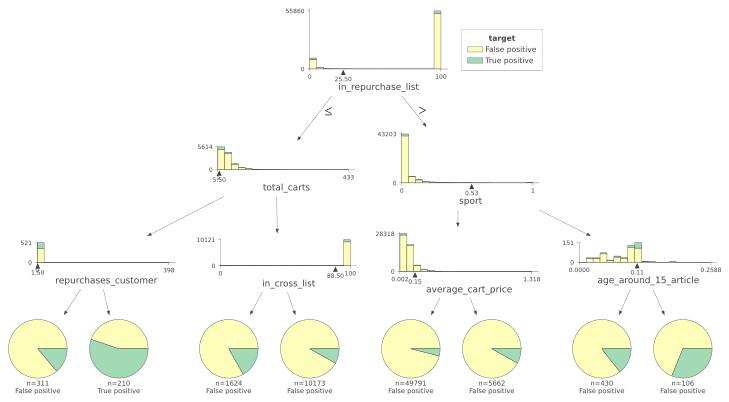

In [36]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(explainer, features, data_to_analyze['is_right'],
                target_name="target",
                feature_names=features.columns,
                class_names=['False positive', 'True positive'])

viz

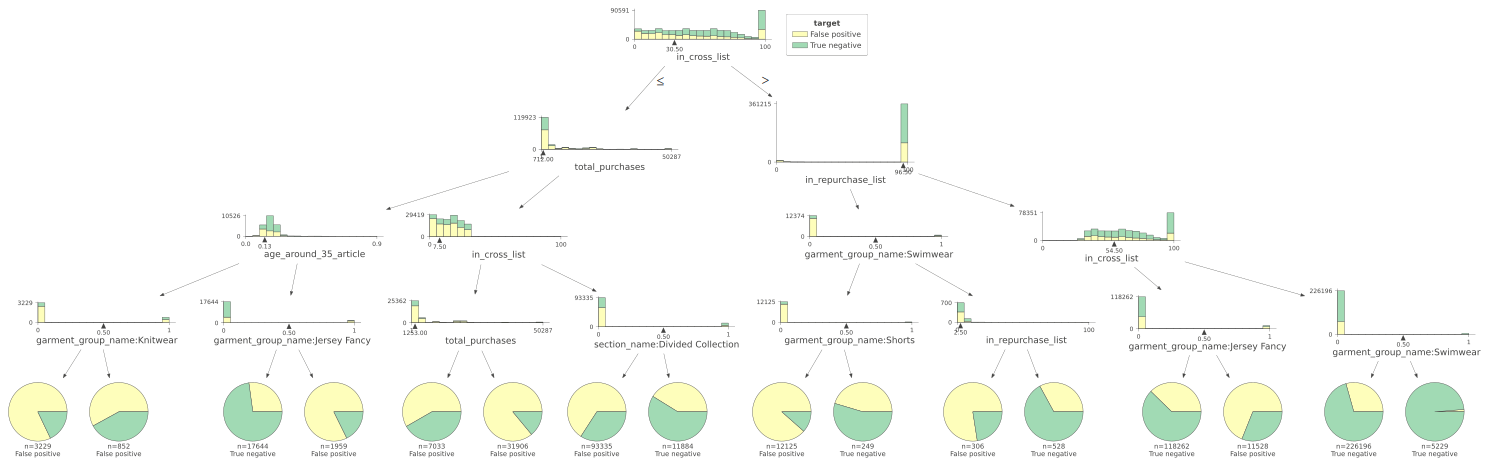

In [57]:
viz

### Soumission de la liste

### Entraînement sur jeu de données multilabel

In [3]:
data_multiclass = pd.read_pickle('pickles/second_iteration_data_train_multilabel.pkl')

In [4]:
categories = ['club_member_status', 'fashion_news_frequency', 'club_member_status', 'FN']

categories_article = ["product_type_name", "product_group_name", 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']

for category in categories_article:
    categories += [f"{category}"]
    
    for i in range(1, 50):
        categories += [f"{category}_{i}"]


#for category in categories:
#    data_multiclass[category] = data_multiclass[category].astype('category')
    
data_multiclass.drop(columns = categories, axis = 1, inplace = True)

In [7]:
data_train, data_valid = train_test_split(data_multiclass, test_size=0.2)

data_train.reset_index(drop = True, inplace = True)
data_valid.reset_index(drop = True, inplace = True)

In [8]:
not_features_columns = ['customer_id', 'article_id', 'purchased_list', 'cross_list', 'pair_list', 'repurchase_list', 'shortlist', 'shortlist_length', 'postal_code'] + [f"article_id_{i}" for i in range(0, 50)] + [f"{i}_label" for i in range(0, 50)]
labels_columns = [f"{i}_label" for i in range(0, 50)]

X_train = data_train.drop(not_features_columns, axis = 1)
Y_train = data_train[labels_columns]
X_valid = data_valid.drop(not_features_columns, axis = 1)
Y_valid = data_valid[labels_columns]

In [9]:
### CHECKPOINT
X_train.to_pickle('pickles/data_multilabel_train_X.pkl')
X_valid.to_pickle('pickles/data_multilabel_valid_X.pkl')
Y_train.to_pickle('pickles/data_multilabel_train_Y.pkl')
Y_valid.to_pickle('pickles/data_multilabel_valid_Y.pkl')
data_train.to_pickle('pickles/data_multilabel_train.pkl')
data_valid.to_pickle('pickles/data_multilabel_valid.pkl')

In [2]:
import pandas as pd 
import xgboost as xgb 

X_train = pd.read_pickle('pickles/data_multilabel_train_X.pkl')
X_valid = pd.read_pickle('pickles/data_multilabel_valid_X.pkl')
Y_train = pd.read_pickle('pickles/data_multilabel_train_Y.pkl')
Y_valid = pd.read_pickle('pickles/data_multilabel_valid_Y.pkl')
data_train = pd.read_pickle('pickles/data_multilabel_train.pkl')
data_valid = pd.read_pickle('pickles/data_multilabel_valid.pkl')

In [10]:
score_chunks = []
import time

for i in range(0, 50):
    print(f"Processing label {i}")
    
    train = xgb.DMatrix(data=X_train, label=Y_train[f"{i}_label"], enable_categorical = True)
    valid = xgb.DMatrix(data=X_valid, label=Y_valid[f"{i}_label"], enable_categorical = True)
    
    params = {'booster': 'gbtree', 'learning_rate': 0.05, 'objective': 'binary:logistic'}
    xgb1 = xgb.train(params = params, dtrain = train, num_boost_round=200, evals=[(train, 'train'), (valid, 'eval')])
    
    prediction = pd.Series(xgb1.predict(valid)).rename('prediction')
    labels = Y_valid[f"{i}_label"].rename('label')
    
    score_chunks.append(
        pd.concat([data_valid['customer_id'], labels, prediction], axis = 1)
    )
    
    time.sleep(2)


Processing label 0


/home/treb/anaconda3/lib/python3.9/site-packages/xgboost/data.py:273: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]


[13:53:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.64542	eval-logloss:0.64547
[1]	train-logloss:0.60228	eval-logloss:0.60233
[2]	train-logloss:0.56302	eval-logloss:0.56311
[3]	train-logloss:0.52720	eval-logloss:0.52732
[4]	train-logloss:0.49439	eval-logloss:0.49453
[5]	train-logloss:0.46423	eval-logloss:0.46441
[6]	train-logloss:0.43646	eval-logloss:0.43665
[7]	train-logloss:0.41080	eval-logloss:0.41103
[8]	train-logloss:0.38705	eval-logloss:0.38732
[9]	train-logloss:0.36503	eval-logloss:0.36532
[10]	train-logloss:0.34457	eval-logloss:0.34490
[11]	train-logloss:0.32553	eval-logloss:0.32590
[12]	train-logloss:0.30778	eval-logloss:0.30819
[13]	train-logloss:0.29123	eval-logloss:0.29168
[14]	train-logloss:0.27577	eval-logloss:0.27627
[15]	train-logloss:0.26131	eval-loglos

In [11]:
score_list = pd.concat(score_chunks)

In [16]:
from utils.map12_from_score_table import map12_from_score_table

map12 = map12_from_score_table(score_list)

print("Score MAP@12: ", map12['map12'].sum() / len(map12))

/var/www/datascientest/pyhm/utils/map12_from_score_table.py:29: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: np.sum(


Score MAP@12:  0.014230433695044155


## Prédiction sur les données de test

In [7]:
from utils.list_to_uniclass import ListToUniclass
from utils.add_uniclass_features import AddUniclassFeatures

In [8]:

data_test = pd.read_pickle('pickles/articles_list_test.pkl')
data_test.head()

customer_id  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   

                                          cross_list  \
0  [0751471001, 0915529003, 0928206001, 057308504...   
1  [0924243001, 0918522001, 0924243002, 090937000...   
2  [0918522001, 0924243001, 0866731001, 092424300...   
3  [0866731001, 0852584001, 0791587001, 091829200...   
4  [0924243001, 0930380001, 0928206001, 091060100...   

                                    repurchase_list  \
0                                                     
1                          [0351484002, 0826211002]   
2                                                     
3                                                     
4  [0927530004, 0896152002, 0730683050, 0791587015]   

                                           pair_list  \
0  [0805000001, 0877278002, 0673396002, 082557900...   
1  [0805406003, 0573085042, 0542402001, 079246900...   
2  [0727808002, 0858883001, 0699080001, 068581300...   
3                                                      
4  [0732206001, 0896152001, 0791587001, 092753000...   

                                           shortlist  
0  [0805000001, 0877278002, 0673396002, 082557900...  
1  [0351484002, 0826211002, 0805406003, 057308504...  
2  [0727808002, 0858883001, 0699080001, 068581300...  
3  [0866731001, 0852584001, 0791587001, 091829200...  
4  [0927530004, 0896152002, 0730683050, 079158701...

In [9]:
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
list_to_uniclass = ListToUniclass()
add_uniclass_features = AddUniclassFeatures(articles, customers)

submission = customers[['customer_id']]
data_test['purchase_list'] = ''

In [ ]:
# Génération de la cross-list par blocs de 50 000 clients.
import gc

length = len(data_test)
index = 0
chunks = []
rows_by_block = 10000

while index < length:
    print (f"\rTraitement des lignes {index} - {index + rows_by_block}              ")
    
    dataset = list_to_uniclass.transform(data_test.loc[index : min(index + rows_by_block, length) - 1])
    dataset = add_uniclass_features.transform(dataset)

    features = dataset.drop(columns = columns_to_drop, axis = 1)
    
    preds_raw = bst.predict(features)
    
    predictions = pd.Series(preds_raw).rename('prediction')
    
    score_list = pd.concat([dataset[['customer_id', 'article_id']], predictions], axis = 1)
    score_list = score_list.sort_values(['customer_id', 'prediction'], ascending = False)
    score_list = score_list.groupby('customer_id', sort = False, as_index = False).agg(
        prediction = ('article_id', lambda x: list(x))
    )
    score_list['prediction'] = score_list['prediction'].apply(lambda x: ' '.join(x[0: 12]))
    
    score_list.to_pickle(f'pickles/temp/test_prediction_{index}-{index + rows_by_block}.pkl')
    
    chunks.append(score_list)
    
    index += rows_by_block
    
    del features
    del dataset
    del preds_raw
    del predictions
    
    gc.collect()
    

In [16]:
for i in range(0, len(chunks)):
    chunks[i].to_pickle(f'pickles/temp_test_prediction_{i + 28}.pkl')

In [18]:
score_list = pd.concat(chunks)

In [20]:
submission = customers[['customer_id']]
submission = submission.merge(score_list, on = 'customer_id', how = 'left')


In [21]:
submission.to_csv('submissions/submission_lightgbm.csv', index=None)

## Conclusion
- Globalement l'approche uniclasse semble mieux fonctionner que l'approche multiclasse, à la fois en résultat et en temps de calcul.
- L'approche ML classique ne semble pas donner de résultat satisfaisants. En particulier la précision est à peine de 2%
- En changeant le nombre de round de boost et la proportion d'échantillons négatifs, **le meilleur score MAP@12 obtenu est de 0.024**.
- Une approche par KMeans ou régression linéaires (avec features polynomiales) serait éventuellement envisageable, mais les recherches précédentes tendent à montrer que ce qui manque à la prédiction a plutôt à voir avec des notions séquentielles et temporelles. 

**Nous pensons donc qu'il est pertinent de continuer avec des modèles de type RNN et GNN plutôt que de tenter de choisir et d'optimiser un modèle classique.**